# encoding

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import cortex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib.ticker import AutoMinorLocator
from statsmodels.stats.multitest import multipletests
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cdist#, pdist, squareform
from scipy.cluster import hierarchy
import statsmodels.formula.api as smf
from sklearn.manifold import MDS
# from surfplot.utils import threshold as surf_threshold

from himalaya.scoring import correlation_score, correlation_score_split
from himalaya.viz import plot_alphas_diagnostic

from util import plot, subject
from util.path import Path
from util.atlas import Atlas, get_brainmask
from util.stats import calculate_pvalues
from encoding import SplitDelayer
from constants import CONVS_STRANGERS, SUBS_STRANGERS, RUNS, RUN_TRIAL_SLICE, BLU, ORG

import warnings

warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
# modelname = "model-gpt2-2b_layer-24"
modelname = "model-opt-7b_layer-23"

# features = ["task", "prod-LLM", "comp-LLM"]
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding"
encmodel = "encoding/trialmot6"

# cache = 'nomot'  # no motion confounds at all
cache = encmodel.split('/')[-1]

modelname, encmodel, cache

('model-opt-7b_layer-23', 'encoding/trialmot6', 'trialmot6')

In [4]:
glasser = Atlas.glasser2016()
schaefer = Atlas.schaefer(1000)
catlas = Atlas.load('custom_glasser')
fgmask = get_brainmask()

In [5]:
def ttest_sig(values: np.ndarray, popmean:int = 0, correlations:bool=True, alternative:str='two-sided', alpha:float=.01, method='bonf'):
    if correlations:
        values = np.arctanh(values)

    ttest = stats.ttest_1samp(values, popmean=popmean, alternative=alternative)

    pvalues = ttest.pvalue
    multiple = multipletests(pvalues[fgmask], alpha=alpha, method=method)

    reject = np.zeros_like(pvalues, dtype=bool)
    reject[*fgmask.nonzero()] = multiple[0]

    return reject

# Figure 2 - model performance

In [93]:
respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print('skip', sub)
        continue
    with h5py.File(respath, "r") as f:
        for key in ["cv_scores_prod", "cv_scores_comp"]: #, "cv_scores"]:
            results[key].append(f[key][...])
        # results['inprod'].append(f['cv_prodmask'][...])
        # for key in ['cv_alphas']:

100%|██████████| 58/58 [00:11<00:00,  5.13it/s]


In [94]:
# scores without splitting into prod/comp time points
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_lang = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean(1)
all_scores_prod.shape

(58, 5, 5, 81924)

In [ ]:
sigmask = ttest_sig(all_scores_lang)
sigmask.sum()

In [ ]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_lang = avg_scores_prod[-2] + avg_scores_comp[-1]
avg_scores_prod.shape

In [ ]:
# gg.argmax(), glasser.labels[308]

In [ ]:
values1 = avg_scores_prod[-2]
values2 = avg_scores_comp[-1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot.surface_plot(values1, threshold=~sigmask, fig=fig, ax=axes[0], vmin=0, cmap='Blues', title="prod")
plot.surface_plot(values2, threshold=~sigmask, fig=fig, ax=axes[1], vmin=0, cmap='Oranges', title="comp")
fig.suptitle(modelname[6:] + f' ({len(features)} spaces) ({cache})')
fig.show()

In [ ]:
plot.surface_plot(values1, vmin=0, cmap='Blues');
plot.surface_plot(values2, vmin=0, cmap='Oranges');

In [ ]:
values1[~sigmask] = np.nan
values2[~sigmask] = np.nan
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)

In [ ]:
fig = cortex.quickflat.make_figure(
    volume,
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
    curvature_brightness=0.7,
    curvature_contrast=0.3,
)

## scatter plot

In [ ]:
values1 = avg_scores_prod[-2][fgmask]
values2 = avg_scores_comp[-1][fgmask]

vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=0.13, vmax2=0.13)(np.vstack((values1, values2)).T)
vox_colors = np.stack((vox_colors)).T / 255

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
# im = ax.hexbin(values1, values2, bins="log", cmap='grey', gridsize=100)
# im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
im = ax.scatter(values1, values2, c=vox_colors, s=20) #, edgecolors="white", linewidths=0.5, s=20, marker='o')
ax.set_aspect("equal", "box")

# roi_labels = {
#     "aTemp": "RH_Lang_aSTS",
#     "pTemp": "RH_Lang_pSTS",
#     "EAC": "RH_AUD_EAC",
# }
# for label, roi in roi_labels.items():
#     roimask = catlas.roimask([roi])
#     x_roi = np.mean(values1[roimask[fgmask]])
#     y_roi = np.mean(values2[roimask[fgmask]])
#     ax.text(
#         x_roi,
#         y_roi,
#         label,
#         ha="center",
#         va="center",
#         size=8,
#         bbox=dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(0.8, 0.8, 0.8)),
#     )

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)

fig.show()

## joint model performance

In [ ]:
brainmask = ~sigmask

fig, axes = plt.subplots(2, 4, figsize=(14, 7), layout='constrained')
# joint
# plot.surface_plot(avg_scores_prod.sum(0), fig=fig, ax=axes[0,0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), fig=fig, ax=axes[1,0], vmin=0.0, cmap="hot")

plot.surface_plot(avg_scores_prod[0], threshold=brainmask, fig=fig, ax=axes[0,0], vmin=0.0, vmax=0.1, cbar=False, cmap="hot")
plot.surface_plot(avg_scores_comp[0], threshold=brainmask, fig=fig, ax=axes[1,0], vmin=0.0, vmax=0.1, cbar=True, cmap="hot")

plot.surface_plot(avg_scores_prod[1], threshold=brainmask, fig=fig, ax=axes[0,1], vmin=0.0, vmax=0.1, cbar=False, cmap="hot")
plot.surface_plot(avg_scores_comp[1], threshold=brainmask, fig=fig, ax=axes[1,1], vmin=0.0, vmax=0.1, cbar=True, cmap="hot")

plot.surface_plot(avg_scores_prod[2], threshold=brainmask, fig=fig, ax=axes[0,2], vmin=0.0, vmax=0.1, cbar=False, cmap="hot")
plot.surface_plot(avg_scores_comp[2], threshold=brainmask, fig=fig, ax=axes[1,2], vmin=0.0, vmax=0.1, cbar=True, cmap="hot")

plot.surface_plot(avg_scores_prod[3], threshold=brainmask, fig=fig, ax=axes[0,3], vmin=0.0, vmax=0.1, cbar=False, cmap="hot")
plot.surface_plot(avg_scores_comp[4], threshold=brainmask, fig=fig, ax=axes[1,3], vmin=0.0, vmax=0.1, cbar=True, cmap="hot")

axes[0,0].set_title('task')
axes[0,1].set_title('spectral')
axes[0,2].set_title('articulation')
axes[0,3].set_title('LLM')

fig.show()

## weighted average

In [ ]:
all_inprod = np.stack(results["inprod"]).sum(-1) * 1.5 / 60
all_inprod.shape

In [ ]:
# get weights based on # of words spoken
dfs = []
for sub in CONVS_STRANGERS:
    df = subject.get_transcript(sub, modelname="model-gpt2-xl_layer-24")

    df["trial"] = ((df["trial"] - 1) % 4) + 1
    df.rename(columns={"speaker": "subject", "word": "words_spoken"}, inplace=True)
    df = df.groupby(["subject", "run", "trial"]).words_spoken.count()

    df2 = df.reset_index()
    df2.rename(columns={"words_spoken": "words_heard"}, inplace=True)
    df2.subject = [i + 100 if i < 100 else i - 100 for i in df2.subject.values]
    df2.set_index(["subject", "run", "trial"], inplace=True)
    dfs.append(pd.concat((df, df2), axis=1))

df_wordcount = pd.concat(dfs)
df_wordcount = df_wordcount.groupby(['subject', 'run']).mean()

sub_words_prod = np.zeros((58, 5))
sub_words_comp = np.zeros((58, 5))
for i, sub in enumerate(SUBS_STRANGERS):
   for j, run in enumerate(RUNS):
        sub_words_prod[i, j] = df_wordcount.loc[(sub, run)].words_spoken
        sub_words_comp[i, j] = df_wordcount.loc[(sub, run)].words_heard

In [ ]:
x = np.arange(58)
y = all_inprod[:, 1]

o = np.argsort(y)[::-1]
y = y[o]

fig, ax = plt.subplots(figsize=(5, 2.5), dpi=120)
ax.bar(x, y, width=1, color=BLU)

ax.set_facecolor(ORG)

ax.set_xlim(-.5, 58-.5)
# ax.set_ylim(0, y.max() * 1.2)
ax.set_ylim(0, 6)
ax.axhline(3, c='k', alpha=0.2)

ax.set(xticks=[], xlabel='subjects')
ax.set(ylabel='total time (m)')

fig.show()

In [ ]:
# compute weighted average over subjects and runs
# all_inprod = np.stack(results["inprod"]).sum(-1)
# weights_prod = all_inprod / all_inprod.sum()
weights_prod = sub_words_prod / sub_words_prod.sum()
wavg_scores_prod = np.sum(all_scores_prod * weights_prod[:, :, None, None], axis=(0, 1))

# all_incomp = 240 - np.stack(results["inprod"]).sum(-1)
# weights_comp = all_incomp / all_incomp.sum()
weights_comp = sub_words_comp / sub_words_comp.sum()
wavg_scores_comp = np.sum(all_scores_comp * weights_comp[:, :, None, None], axis=(0, 1))

wavg_scores_prod.shape

## dual cmap plot

### pycortex

In [ ]:
feature_vols = {}
for i, feature in enumerate(features[:-2]):
    values1 = all_scores_prod[:, :, i].mean((0, 1))
    values2 = all_scores_comp[:, :, i].mean((0, 1))
    values1 = plot.upsample_fsaverage(values1)
    values2 = plot.upsample_fsaverage(values2)

    vmin1 = 0
    vmin2 = 0
    # vmin1 = np.quantile(values1, 0.75)
    # vmin2 = np.quantile(values2, 0.75)
    # values1[values1 < vmin1] = np.nan
    # values2[values2 < vmin2] = np.nan

    volume = cortex.Vertex2D(
        values1,
        values2,
        "fsaverage",
        cmap="PU_BuOr_covar",
        vmin=vmin1,
        vmin2=vmin2,
    )

    feature_vols[feature] = volume

In [ ]:
# sigmask = (avg_scores_prod[-2] + avg_scores_comp[1]) < .04
sigmask = plot.upsample_fsaverage(avg_scores_prod[-2] + avg_scores_comp[1]) < .04

In [ ]:
feature_vols = {}
values1 = avg_scores_prod[-2]
values2 = avg_scores_comp[-1]
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
# vmin1, vmin2 = .04, .04
# vmin1 = np.quantile(values1, 0.75)
# vmin2 = np.quantile(values2, 0.75)
values1[sigmask] = np.nan
values2[sigmask] = np.nan
# volume = cortex.Vertex2D(values1, values2, 'fsaverage', cmap='PU_BuOr_covar', vmin=vmin1, vmin2=vmin2)
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)
feature_vols["LLM"] = volume

In [ ]:
feature_vols = {}
values1 = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean((0, 1))
values2 = ((all_scores_prod[:, :, 1:-2].sum(2) + all_scores_comp[:, :, 1:-2].sum(2)) / 2).mean((0, 1))
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
# vmin1, vmin2 = .04, .04
# vmin1 = np.quantile(values1, 0.75)
# vmin2 = np.quantile(values2, 0.75)
values1[sigmask] = np.nan
values2[sigmask] = np.nan
# volume = cortex.Vertex2D(values1, values2, 'fsaverage', cmap='PU_BuOr_covar', vmin=vmin1, vmin2=vmin2)
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)
feature_vols["LLMvLL"] = volume

In [ ]:
feature_vols = {}
values1 = plot.upsample_fsaverage(avg_scores_prod[-2].astype(np.float32))
values2 = plot.upsample_fsaverage(avg_scores_comp[-1].astype(np.float32))
vmin1, vmin2 = None, None
feature_vols["prodLLM"] = cortex.Vertex(values1, "fsaverage", cmap="hot", vmin=vmin1)
feature_vols["compLLM"] = cortex.Vertex(values2, "fsaverage", cmap="hot", vmin=vmin2)

In [ ]:
# joint model
values1 = all_scores_prod.sum(2).mean((0, 1))
values2 = all_scores_comp.sum(2).mean((0, 1))
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
# print(np.quantile(values1, 0.75))
# print(np.quantile(values2, 0.75))
volume = cortex.Vertex2D( values1, values2, "fsaverage", cmap="PU_BuOr_covar", )
feature_vols["full"] = volume

In [ ]:
# make flatmaps
outdir = '/'.join(['figures', encmodel , modelname])
!mkdir -p $outdir

for i, (feature, volume) in enumerate(feature_vols.items()):
    cortex.quickflat.make_png(
        f"{outdir}/{i}-{feature}.png",
        volume,
        with_sulci=True,
        with_rois=False,
        with_labels=False,
        with_curvature=True,
    )

In [ ]:
fig = cortex.quickflat.make_figure(
    feature_vols["LLM"],
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
)

In [ ]:
h = cortex.webshow(
    feature_vols["full"]
)  # , recache=not True, overlays_visible=(), labels_visible=())

### matplotlib

In [ ]:
I = plt.imread("mats/PU_BuOr_covar.png")
plt.imshow(I)

In [ ]:
# flat_cmap = mcolors.ListedColormap(I.transpose((1,0,2)).reshape(256*256, -1), name='my2dT')
flat_cmap = mcolors.ListedColormap(I.reshape(256 * 256, -1), name="my2d")
flat_cmap.set_under(I[255, 0])
flat_cmap.set_over(I[0, 255])
flat_cmap

In [ ]:
from matplotlib.colors import Normalize


def convert(X, vmin=0, vmax=1, vmin2=None, vmax2=None, n=256):
    data1 = X[:, 0]
    data2 = X[:, 1]

    vmin2 = vmin2 if vmin2 is not None else vmin
    vmax2 = vmax2 if vmax2 is not None else vmax

    norm1 = Normalize(vmin, vmax)
    norm2 = Normalize(vmin2, vmax2)

    d1 = np.clip(1 - norm1(data1), 0, 1)
    d2 = np.clip(norm2(data2), 0, 1)
    dim1 = np.round(d1 * (256 - 1))
    dim1 = np.nan_to_num(dim1).astype(np.uint32)
    dim2 = np.round(d2 * (256 - 1))
    dim2 = np.nan_to_num(dim2).astype(np.uint32)

    flat_indices = np.ravel_multi_index((dim1, dim2), dims=(n, n))
    return flat_indices

In [ ]:
print(I[0, 0])
print(I[255, 0])
print(I[0, 255])
print(I[255, 255])

In [ ]:
for i in range(2):
    for j in range(2):
        flatid = convert(np.array([[i, j]]))[0]
        parts = np.unravel_index(flatid, shape=(256, 256))
        print(i, j, f"{flatid:5d}", parts, flat_cmap(flatid))

In [ ]:
import sys
from importlib import reload

reload(sys.modules["surfplot"])
reload(sys.modules["surfplot.surf"])
reload(sys.modules["surfplot.plotting"])
from surfplot import Plot
from util import plot

from pathlib import PosixPath

In [ ]:
i = 0
values1 = all_scores_prod[:, :, i].mean((0, 1))
values2 = all_scores_comp[:, :, i].mean((0, 1))
# vals = np.stack((values1, values2)).T
vals = np.stack((values1, values1)).T
vals.shape

In [ ]:
vals.max(0)

In [ ]:
rand_vals = np.zeros_like(vals)
rand_vals[:, 0] = 0.9
rand_vals[:, 1] = 0

In [ ]:
new_vals = convert(rand_vals)  # , vmax=.1, vmax2=.1)
new_vals.min(), new_vals.max()

In [ ]:
flat_cmap(6656)

In [ ]:
# p = Plot(surf_lh=surf_lh, surf_rh=surf_rh)
p = plot.get_surfplot()
p.add_layer(new_vals, cmap=flat_cmap, cbar=True, color_range=(0, flat_cmap.N))
fig = p.build()
fig.show()

In [ ]:
vals[:, 0].argmax()
vals[:, 1].argmax()
vals[:, 0].argmin()
vals[:, 1].argmin()

In [ ]:
i = 20623
i = 73970
i = 12059
vals[i], new_vals[i]

In [ ]:
np.unravel_index(43008, shape=(256, 256))

In [ ]:
flat_cmap(43008)

In [ ]:
from matplotlib.patches import Rectangle

color = flat_cmap(6656)
print(color)

fig, ax = plt.subplots(figsize=(6.5, 1.65), layout="constrained")
ax.add_patch(Rectangle((-0.2, -0.35), 11.2, 0.7, color=color))
ax.set_xlim(-0.2, 13)
ax.set_ylim(-1, 1)
ax.axis("off")
fig.show()

In [ ]:
# [s for s in sys.modules.keys() if 'surf' in s]
from pathlib import PosixPath

surf_lh = plot._image_cache[
    PosixPath("mats/atlases/fsaverage/tpl-fsaverage_den-41k_hemi-L_inflated.surf.gii")
]
surf_rh = plot._image_cache[
    PosixPath("mats/atlases/fsaverage/tpl-fsaverage_den-41k_hemi-R_inflated.surf.gii")
]

In [ ]:
# p = Plot(surf_lh=surf_lh, surf_rh=surf_rh)
p = plot.get_surfplot()
p.add_layer(new_vals, cmap=flat_cmap, cbar=True, color_range=(0, 65536))
fig = p.build()
fig.show()

## rois

composition

In [ ]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
scoresC = catlas.vox_to_parc(avg_scores_comp)
scoresP.shape

In [ ]:
df = pd.DataFrame(index=catlas.labels)
df['task'] = scoresP[0] + scoresC[0]
df['spectral'] = scoresP[1] + scoresC[1]
df['articulation'] = scoresP[2] + scoresC[2]
df['prod-LLM'] = scoresP[3]
df['comp-LLM'] = scoresC[4]
df.head()

In [ ]:
width = 0.5

fig, ax = plt.subplots(figsize=(10, 4.8))

subdf = df.iloc[21:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ['#333333', '#7f7f7f', '#CCCCCC', BLU, ORG]

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xlabels, values, width, label=feature, bottom=bottom, color=color)
    bottom += values

ax.set_xticklabels(xlabels, rotation=90)

ax.set_title("joint model perf composition")
ax.legend(loc="upper right", frameon=False)
sns.despine(fig)

plt.show()

subject distribution 

In [ ]:
sub_scores_prod = all_scores_prod[:, :, -2].mean(1)
sub_scores_comp = all_scores_comp[:, :, -1].mean(1)

In [ ]:
sub_run_prod_red = atlas.vox_to_parc(sub_scores_prod)
sub_run_comp_red = atlas.vox_to_parc(sub_scores_comp)
sub_run_prod_red.shape

In [ ]:
df_enc_roi = pd.DataFrame()
df_enc_roi["subject"] = SUBS_STRANGERS
for i, col in enumerate(atlas.labels):
    df_enc_roi["prod_" + col] = sub_run_prod_red[..., i]
for i, col in enumerate(atlas.labels):
    df_enc_roi["comp_" + col] = sub_run_comp_red[..., i]
df_enc_roi.set_index("subject", inplace=True)
df_enc_roi.head()

In [ ]:
df_enc_roi_melted = pd.melt(df_enc_roi)
df_enc_roi_melted["mode"] = df_enc_roi_melted.variable.apply(lambda x: x[:4])
df_enc_roi_melted["hemi"] = df_enc_roi_melted.variable.apply(lambda x: x[5:7])
df_enc_roi_melted["ROI"] = df_enc_roi_melted.variable.apply(lambda x: x.split("_")[-1])
df_enc_roi_melted

In [ ]:
g = sns.catplot(
    df_enc_roi_melted,
    col="mode",
    x="ROI",
    y="value",
    hue="hemi",
    dodge=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
for ax in g._axes.ravel():
    ax.axhline(0.047535990572474214, c='k', ls=':')
plt.show()

In [ ]:
ax = sns.catplot(
    df_enc_roi_melted,
    col="hemi",
    x="ROI",
    y="value",
    hue="mode",
    dodge=True,
    kind="box",
)
ax.set_xticklabels(rotation=30)
# ax.set_xticklabels(labels, rotation=90)
plt.show()

## check alphas

In [ ]:
feat_alphas = np.stack(results["cv_alphas"]).mean((1))  # average over folds
# feat_alphas = np.swapaxes(feat_alphas, 0, 1).reshape(6, -1)
feat_alphas.shape

In [ ]:
features = ["nuisance", "spectral", "phonemes", "production", "comprehension"]

alpha_range = np.logspace(0, 19, 20)
fig, ax = plt.subplots()
plot_alphas_diagnostic(feat_alphas.flatten(), alpha_range, ax=ax)
plt.title("Best alphas selected by cross-validation")
plt.show()

In [ ]:
plt.hexbin(
    sub_scores_prod.flatten(),
    np.log10(feat_alphas).flatten(),
    bins="log",
    cmap="inferno",
)
# ax.hexbin(within[rmask], between[rmask], bins='log', cmap='inferno', gridsize=24)

In [ ]:
plt.hexbin(
    sub_scores_comp.flatten(),
    np.log10(feat_alphas).flatten(),
    bins="log",
    cmap="inferno",
)

In [ ]:
values = np.log10(feat_alphas.mean(0))
fig = plot.surface_plot(values, vmin=0, vmax=12, cmap="Reds_r")

## rescore

In [ ]:
re_scores = defaultdict(list)
delayer = SplitDelayer(delays=[2, 3, 4, 5])

for subA in tqdm(SUBS_STRANGERS):
    # get data
    dataA = subject.get_bold(subA, use_cache=True, cache_desc=cache)
    _, switches = subject.get_button_presses(subA)
    prodmaskA = switches.astype(bool)
    prodmaskA = delayer.fit_transform(prodmaskA[:, None]).any(-1)
    compmaskA = ~prodmaskA

    # load subA preds
    encpath = Path(
        root=encmodel,
        sub=f"{subA:03d}",
        datatype=modelname,
        ext=".hdf5",
    )
    with h5py.File(encpath, "r") as f:
        # prod_predA = f["cv_preds"][:, -2]  # (5, 6, 240, 81924)
        # comp_predA = f["cv_preds"][:, -1]
        predA = f["cv_preds"][...]

    prod_scores = np.zeros((5, len(features), 81924), dtype=np.float32)
    comp_scores = np.zeros((5, len(features), 81924), dtype=np.float32)
    for k, i in enumerate(range(0, 1200, 240)):
        trial_slc = slice(i, i + 240)
        trial_pred = predA[k]
        trial_data = dataA[trial_slc]
        trial_prodmask = prodmaskA[trial_slc]
        trial_compmask = compmaskA[trial_slc]
        prod_scores[k] = correlation_score_split(
            trial_data[trial_prodmask], trial_pred[:, trial_prodmask]
        )
        comp_scores[k] = correlation_score_split(
            trial_data[trial_compmask], trial_pred[:, trial_compmask]
        )

    with h5py.File(encpath, "r+") as f:  # Read/write, file must exist
        fdata = f["cv_scores_prod"]
        fdata[...] = prod_scores
        fdata = f["cv_scores_comp"]
        fdata[...] = comp_scores

        # fdata = f['prod_scores']
        # fdata[...] = prod_scores
        # fdata = f['comp_scores']
        # fdata[...] = comp_scores

        # f.create_dataset(name='prod_scores', data=prod_scores)
        # f.create_dataset(name='comp_scores', data=comp_scores)

In [ ]:
predAsw = np.swapaxes(predA, 0, 1)
full_tr_score = correlation_score_split(dataA[prodmaskA], predAsw.reshape(6, 1200, -1)[:, prodmaskA])

In [ ]:
full_tr_score_comp = correlation_score_split(dataA[compmaskA], predAsw.reshape(6, 1200, -1)[:, compmaskA])

In [ ]:
plt.scatter(prod_scores[:, -2].mean(0), full_tr_score[-2])
plt.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
plt.xlabel('avg fold corrs')
plt.ylabel('concat folds')
plt.show()

In [ ]:
plt.scatter(comp_scores[:, -1].mean(0), full_tr_score_comp[-1])
plt.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
plt.xlabel('avg fold corrs')
plt.ylabel('concat folds')
plt.show()

In [ ]:
prod_scores.mean(0).argmax(), comp_scores.mean(0).argmax()

In [ ]:
inprod = prodmaskA[:240]

In [ ]:
v = 24119
v = 63870
fig, ax = plt.subplots(figsize=(14, 5))

switches = [0] + np.nonzero(np.diff(inprod))[0].tolist() + [240]
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)

# ax.plot(dataA[:240, v], c='black')
# ax.twinx().plot(prod_predA[0, :, v] + comp_predA[0, :, v], c='blue')

ax.plot(prod_predA[0, :, v], c="blue")
ax.twinx().plot(comp_predA[0, :, v], c="red")

fig.show()

In [ ]:
# # diff between scoring methods??
# from himalaya.scoring import correlation_score_split
# s1 = correlation_score_split(dataA[trial_slc], Y_predsA[0])
# s1.shape
# s2 = correlation_score(dataA[trial_slc], Y_predsA[0, -2])
# s2.shape

In [ ]:
# # validate prod masks
# from encoding import build_regressors
# _, swA = subject.get_button_presses(subA)
# _, swB = subject.get_button_presses(subject.get_partner(subA))
# xA, _ = build_regressors(subA, modelname=modelname)
# xB, _ = build_regressors(subject.get_partner(subA), modelname=modelname)
# assert np.allclose(swA, 1-swB)
# assert np.allclose(xA[:, 1], swA)
# assert np.allclose(xA[:, 5], swB)
# assert np.allclose(xB[:, 1], swB)
# assert np.allclose(xB[:, 5], swA)

## compare models

In [12]:
from glob import glob
files = glob('features/conv/**/*.csv')
dfs = []
for filename in files:
    df = pd.read_csv(filename)
    family, size = filename.split('/')[2].split('-', maxsplit=1)
    # df.insert(1, 'size', size)
    # df.insert(1, 'family', family)
    df.insert(1, 'model', family + '-' + size)
    dfs.append(df.iloc[:, 1:])
dfm = pd.concat(dfs)
dfm

,model,top1_acc,perplexity
0,opt-3b,0.426160,15.288000
1,opt-3b,0.389169,16.921551
2,opt-3b,0.387050,15.494808
3,opt-3b,0.447596,13.191471
4,opt-3b,0.408369,14.408988
...,...,...,...
574,olmo-7b-chat,0.440602,15.247249
575,olmo-7b-chat,0.383901,20.555567
576,olmo-7b-chat,0.453172,15.304327
577,olmo-7b-chat,0.383973,22.534941


In [13]:
modelmeta = pd.read_csv('mats/models.csv')
modelmeta['sizeapprox'] = modelmeta.num_layers * modelmeta.hidden_size
modelmeta.set_index('model', inplace=True)
modelmeta

,num_layers,hidden_size,max_positions,sizeapprox
model,,,,
opt-125m,12,768,2048,9216
opt-350m,24,1024,2048,24576
opt-2b,24,2048,2048,49152
opt-3b,32,2560,2048,81920
opt-7b,32,4096,2048,131072
opt-13b,40,5120,2048,204800
olmo-1b,16,2048,2048,32768
olmo-7b,32,4096,2048,131072
olmo-7b-chat,32,4096,2048,131072


In [14]:
# sns.barplot(data=dfm, x='model', y='perplexity', hue='size')
dfg = dfm.groupby('model').mean()#.sort_values('perplexity')
dfg = dfg.join(modelmeta, how='left').reset_index()
dfg['family'] = dfg.model.apply(lambda x: x.split('-')[0])
dfg

,model,top1_acc,perplexity,num_layers,hidden_size,max_positions,sizeapprox,family
0,gpt2-124m,0.373419,20.205300,12.0,768.0,1024.0,9216.0,gpt2
1,gpt2-355m,0.393123,17.073242,24.0,1024.0,1024.0,24576.0,gpt2
2,gpt2-774m,0.402787,15.611128,36.0,1280.0,1024.0,46080.0,gpt2
3,gpt2-82m,0.341699,25.937440,NaN,NaN,NaN,NaN,gpt2
4,llama-7b,0.483596,9.070271,32.0,4096.0,2048.0,131072.0,llama
5,llama2-7b,0.487487,8.871347,32.0,4096.0,4096.0,131072.0,llama2
6,mistral-7b,0.482773,9.033235,32.0,4096.0,32768.0,131072.0,mistral
7,neo-125m,0.311363,39.608746,12.0,768.0,2048.0,9216.0,neo
8,neo-1b,0.387171,19.763215,24.0,2048.0,2048.0,49152.0,neo
9,neo-3b,0.397354,18.025075,32.0,2560.0,2048.0,81920.0,neo


In [17]:
dfg.sort_values('perplexity')

,model,top1_acc,perplexity,num_layers,hidden_size,max_positions,sizeapprox,family
5,llama2-7b,0.487487,8.871347,32.0,4096.0,4096.0,131072.0,llama2
6,mistral-7b,0.482773,9.033235,32.0,4096.0,32768.0,131072.0,mistral
4,llama-7b,0.483596,9.070271,32.0,4096.0,2048.0,131072.0,llama
11,olmo-7b,0.437114,13.851683,32.0,4096.0,2048.0,131072.0,olmo
17,opt-7b,0.429151,14.153264,32.0,4096.0,2048.0,131072.0,opt
16,opt-3b,0.421451,15.207380,32.0,2560.0,2048.0,81920.0,opt
2,gpt2-774m,0.402787,15.611128,36.0,1280.0,1024.0,46080.0,gpt2
14,opt-2b,0.412580,16.455981,24.0,2048.0,2048.0,49152.0,opt
1,gpt2-355m,0.393123,17.073242,24.0,1024.0,1024.0,24576.0,gpt2
9,neo-3b,0.397354,18.025075,32.0,2560.0,2048.0,81920.0,neo


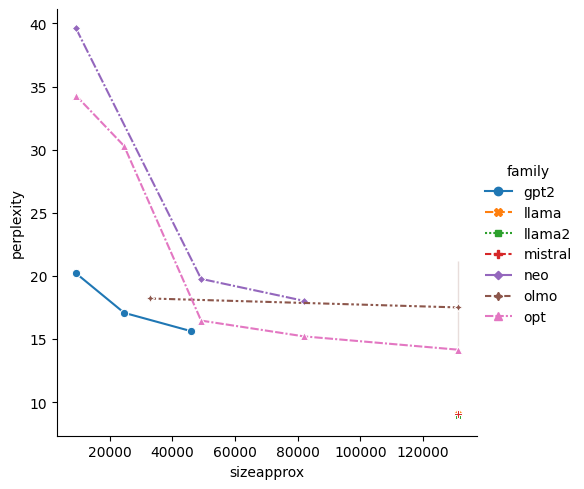

In [15]:
sns.relplot(data=dfg, x='sizeapprox', y='perplexity', style='family', hue='family', kind='line', markers=True)

In [16]:
dfb = dfg.set_index('model').loc[['gpt2-2b', 'neo-3b', 'opt-7b', 'llama-7b', 'llama2-7b', 'mistral-7b']].reset_index()
ax = sns.barplot(data=dfb, x='model', y='perplexity')

KeyError: "['gpt2-2b'] not in index"

In [ ]:
respath = Path(
    root="encoding_trialmot6",
    sub="000",
    datatype="",
    ext=".hdf5",
)

models = [
"model-mistral-7b_layer-10",
"model-mistral-7b_layer-16",
"model-mistral-7b_layer-23",
"model-llama-7b_layer-10",
"model-llama-7b_layer-16",
"model-llama-7b_layer-23",
"model-opt-7b_layer-10",
"model-opt-7b_layer-16",
"model-opt-7b_layer-23",
"model-gpt2-2b_layer-14",
"model-gpt2-xl_layer-24",
"model-gpt2-2b_layer-34",
"model-neo-3b_layer-10",
"model-neo-3b_layer-16",
"model-neo-3b_layer-23",
]

# alphas = defaultdict(list)
model_results_prod = defaultdict(list)
model_results_comp = defaultdict(list)
for model in models:
    respath.update(datatype=model)
    for sub in tqdm(SUBS_STRANGERS):
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            print('skip', model, sub)
            continue
        with h5py.File(respath, "r") as f:
            model_results_prod[model].append(f["cv_scores_prod"][:, -2, :])
            model_results_comp[model].append(f["cv_scores_comp"][:, -1, :])
            # alphas[model].append(f["cv_alphas"][...])

[(key, len(values)) for key, values in model_results_prod.items()]

In [ ]:
atlas = Atlas.load('langrois_glasser')
brainmask = atlas.label_img > 0
brainmask.sum()

In [ ]:
records = []
for model in model_results_prod.keys():
    parts = model.replace('xl', '2b').split('_')
    family, size = parts[0].split('-')[1:]
    layer = int(parts[-1].split('-')[-1])
    maxlayer = 32 if 'gpt2' not in model else 48
    for mode, result in zip(['prod', 'comp'], [model_results_prod, model_results_comp]):
        values = np.stack(result[model])
        brainscore = values.mean()
        brainscore2 = values[..., brainmask].mean()
        records.append((mode, family + '-' + size, size, layer, layer / maxlayer, brainscore, brainscore2))

cols = ['mode', 'family', 'size', 'layer', 'layer_norm', 'score', 'lang_score']
df = pd.DataFrame(records, columns=cols)
df.sort_values(['mode', 'lang_score'])

In [ ]:
sns.relplot(df, x='layer_norm', y='lang_score', style='family', hue='family', col='mode', kind='line', markers=True, dashes=True)

In [ ]:
alpha_range = np.logspace(0, 19, 20)
fig, ax = plt.subplots()
plot_alphas_diagnostic(np.stack(alphas[models[0]]).mean(1).ravel(), alpha_range, ax=ax)
plot_alphas_diagnostic(np.stack(alphas[models[1]]).mean(1).ravel(), alpha_range, ax=ax)
plot_alphas_diagnostic(np.stack(alphas[models[2]]).mean(1).ravel(), alpha_range, ax=ax)
plot_alphas_diagnostic(np.stack(alphas[models[3]]).mean(1).ravel(), alpha_range, ax=ax)
plt.title("Best alphas selected by cross-validation")
plt.show()

# narrative

In [ ]:
# not all subjects have this..
SUBS_NAR = list(SUBS_STRANGERS)
SUBS_NAR.remove(11)
SUBS_NAR.remove(111)
SUBS_NAR.remove(12)

## isc

In [ ]:
from sklearn.model_selection import LeaveOneOut

In [ ]:
n_subs = len(SUBS_NAR)

cache_path = Path(
    root="data/derivatives/cleaned",
    datatype="func",
    sub="000",
    task="Black",
    space="fsaverage6",
    suffix="bold",
    ext="hdf5",
)

sub_bolds = []
for sub in tqdm(SUBS_NAR):
    cache_path.update(sub=f"{sub:03d}")
    with h5py.File(cache_path, 'r') as f:
        sub_bolds.append(f['bold'][...])

sub_bolds = np.stack(sub_bolds)
sub_bolds.shape

In [ ]:
iscs = np.zeros((n_subs, sub_bolds.shape[-1]))

loo = LeaveOneOut()
splits = loo.split(range(n_subs))
for i, (train_index, test_index) in tqdm(enumerate(splits), total=n_subs):
    sub_bold = sub_bolds[test_index]
    group_bold = sub_bolds[train_index].mean(0)
    iscs[i] = correlation_score(group_bold, sub_bold)

In [ ]:
fig = plot.surface_plot(iscs.mean(0), vmin=0.1, threshold='vmin', cmap='hot')

## ise

In [ ]:
# load black preds
respath = Path(
    root="encoding/black",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

sub_preds = []
for sub in tqdm(SUBS_NAR):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, 'r') as f:
        sub_preds.append(f['cv_preds'][1, -1])

sub_preds = np.stack(sub_preds)
sub_preds.shape

In [ ]:
oos_ises = np.zeros((n_subs, 81924), dtype=np.float32)

loo = LeaveOneOut()
splits = loo.split(range(n_subs))
for i, (train_index, test_index) in tqdm(enumerate(splits), total=n_subs):
    sub_pred = sub_preds[test_index]
    group_preds = sub_preds[train_index].mean(0)
    oos_ises[i] = correlation_score(group_preds, sub_pred)

In [ ]:
# load black preds
respath = Path(
    root="encoding/black",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

ises = np.zeros((n_subs, 81924), dtype=np.float32)

loo = LeaveOneOut()
splits = loo.split(range(n_subs))
for i, (train_index, test_index) in tqdm(enumerate(splits), total=n_subs):
    group_bold = sub_bolds[train_index].mean(0)

    subId = SUBS_NAR[test_index.item()]
    respath.update(sub=f"{subId:03d}")
    with h5py.File(respath, "r") as f:
        sub_preds = f["cv_preds"][:, -1, :].reshape(534, 81924)  # -1 gets LLM preds
    ises[i] = correlation_score(group_bold, sub_preds)


In [ ]:
fig = plot.surface_plot(ises.mean(0), cmap='hot', vmin=0)

In [ ]:
outdir = f'cache/{modelname}/narrative'
!mkdir -p $outdir
with h5py.File(f"{outdir}/intersubject.hdf5", "w") as f:
    f.create_dataset(name="isc", data=iscs)
    f.create_dataset(name="ise", data=ises)
    f.create_dataset(name="enc", data=black_feat_scores[-1])

In [ ]:
within = black_feat_scores[-1]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
plot.surface_plot(iscs.mean(0), fig=fig, ax=axes[0], cmap="hot", title="ISC", vmin=0)
plot.surface_plot(within, fig=fig, ax=axes[1], cmap="hot", title="encoding", vmin=0)
plot.surface_plot(ises.mean(0), fig=fig, ax=axes[2], cmap="hot", title="ISE", vmin=0)
fig.show()

In [ ]:
# values1 = iscs.mean(0)
values1 = ises.mean(0)
values2 = black_feat_scores[-1]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
# ax.set_aspect("equal", "box")

# lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
# ax.set_xlim(ax.get_xlim()[0], lim)
# ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("ISE (r)")
ax.set_ylabel("Encoding (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)
fig.show()

In [ ]:
tt = stats.ttest_1samp(black_sub_scores[:, -1, :], popmean=0, alternative='greater')
reject, _, _, _ = multipletests(tt.pvalue, alpha=0.01, method='fdr_bh')
reject.sum()

In [ ]:
within2 = black_feat_scores[-1].copy()
print(within2[reject].min())
within2[~reject] = 0
plot.surface_plot(within2, cmap="hot", title="encoding", vmin=0);

In [ ]:
df_scores = pd.read_csv('mats/black_comprehension.csv', index_col='ID')

In [ ]:
atlas = Atlas.load('custom_glasser')
print(len(atlas))
brainmask = atlas.label_img > 0
brainmask.sum()

In [ ]:
brainmask = reject

In [ ]:
# brainmask = None

records = []
for i, sub in enumerate(SUBS_NAR):
    # isc = iscs[i, brainmask].mean()
    # enc = black_sub_scores[i, -1, brainmask].mean()
    # ise = ises[i, brainmask].mean()
    ise = oos_ises[i, brainmask].mean()
    comp = df_scores.loc[sub].comprehension_score
    # records.append((isc, enc, ise, comp))
    records.append((ise, comp))

df = pd.DataFrame(records, columns=['oos_ise', 'comp']) #'isc', 'enc', 'ise', 'comp'])

In [ ]:
df.corr('spearman')  # lang areas only

In [ ]:
sns.regplot(df, x='comp', y='oos_ise')

In [ ]:
comp_scores = df.comp.to_numpy().reshape(-1, 1)

In [ ]:
# corrs = correlation_score(comp_scores, glasser.vox_to_parc(iscs))

# corrs = correlation_score(comp_scores, iscs)
# corrs = correlation_score(comp_scores, ises)
corrs = correlation_score(comp_scores, oos_ises)
# corrs = correlation_score(comp_scores, black_sub_scores[:, -1])
corrs = glasser.vox_to_parc(corrs)
corrs.shape

In [ ]:
plot.surface_plot(glasser.parc_to_vox(corrs), cmap='hot', vmin='quantile', threshold='vmin');

## one model

In [ ]:
# load black results

respath = Path(
    root="encoding/black",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

black_results = defaultdict(list)
for sub in tqdm(SUBS_NAR):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        black_results["cv_scores"].append(f["cv_scores"][:, :, :])

black_scores = np.stack(black_results["cv_scores"])
black_scores.shape

In [ ]:
black_sub_scores = black_scores.mean(1)
black_feat_scores = black_sub_scores.mean(0)
black_feat_scores.shape

In [ ]:
atlas = Atlas.glasser2016()

In [ ]:
fig = plot.surface_plot(black_feat_scores[-1], vmin=0, cmap="hot")

In [ ]:
for i, feature in enumerate(["task", "spectral", "articulation", "comp"]):
    values = black_feat_scores[i]
    fig = plot.surface_plot(values, vmin=0, cmap="hot", title=f"black {feature}")

In [ ]:
values = black_feat_scores[-1]
values = plot.upsample_fsaverage(values)
volume = cortex.Vertex(values, "fsaverage", cmap="hot")

In [ ]:
fig = cortex.quickflat.make_figure(volume)

## compare layers

In [ ]:
# load black results

respath = Path(
    root="encoding/black",
    sub="000",
    datatype="Llama-2-7b-hf",
    task="Black",
    desc="layer-X",
    ext=".hdf5",
)

black_lag_results = defaultdict(list)
for layer in tqdm(np.arange(34)):
    respath.update(desc=f"layer-{layer}")
    for sub in SUBS_STRANGERS:
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            continue
        with h5py.File(respath, "r") as f:
            black_lag_results[layer].append(f["cv_scores"][:, -1, :])

In [ ]:
layers = list(black_lag_results.keys())
means = [np.mean(res) for res in black_lag_results.values()]
errs = [np.std(res) for res in black_lag_results.values()]
len(means)

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(layers, means, yerr=np.array(errs) / 640)  # np.sqrt(5 * 81924)
 
# Style the grid.
ax.set_facecolor("#EBEBEB")
ax.grid(which="major", color="white", linewidth=1.2)
ax.grid(which="minor", color="white", linewidth=0.6)
ax.minorticks_on()
ax.tick_params(which="minor", bottom=False, left=False)

max_layer = np.argmax(means)
ax.axvline(max_layer, c='k', ls='--')

# ax.annotate('max', (max_layer, means[max_layer]), verticalalignment='bottom', horizontalalignment='left')

ax.set(xlabel='layer', ylabel='avg enc performance (r)', title='story encoding (llama2-7b)')

ax.set_ylim(0, ax.get_ylim()[1])
sns.despine(fig)

fig.show()

## compare models

In [ ]:

# load black results

respath = Path(
    root="encoding/black",
    sub="000",
    datatype="temp",
    task="Black",
    desc="layer-16",
    ext=".hdf5",
)

# models = ['gptneo-3b', 'Llama-2-7b-hf', 'llama2-7b', 'mistral-7b']

models = [
"opt-125m",
"opt-350m",
"opt-2b",
"opt-3b",
"opt-7b",
"llama2-7b",
]

layers = [6, 12, 12, 16, 16, 16]

black_model_results = defaultdict(list)
for model, layer in tqdm(zip(models, layers)):
    respath.update(datatype=model)
    respath.update(desc=f"layer-{layer}")
    if model.startswith('llama2'):
        respath.update(desc="layer-16_n")  # NOTE temporary fix
    for sub in SUBS_STRANGERS:
        respath.update(sub=f"{sub:03d}")
        if not respath.isfile():
            continue
        with h5py.File(respath, "r") as f:
            black_model_results[model].append(f["cv_scores"][:, -1, :])

[(key, len(values)) for key, values in black_model_results.items()]

In [ ]:
i = 5
values = np.stack(black_model_results[models[i]]).mean((0, 1))
plot.surface_plot(values, cmap='inferno', vmin=0, title=models[i]);

In [ ]:
atlas = Atlas.load('langrois_glasser')
brainmask = atlas.label_img > 0
brainmask.sum()

In [ ]:
# brainmask = None
means = [np.stack(res)[..., brainmask].mean() for res in black_model_results.values()]
errs = [np.stack(res)[..., brainmask].std() / 200 for res in black_model_results.values()]
len(means)

In [ ]:
ax = sns.barplot(x=models, y=means, yerr=errs);
ax.set_ylabel('avg enc. performance (r)')
ax.set_title('story comprehension middle layer')

# Figure 2 - MBc

In [ ]:
mbc_scores = defaultdict(list)
# delayer = SplitDelayer(delays=[2, 3, 4, 5])

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsA = f["cv_preds"][...]  # (5, 6, 240, 81924)
        prod_predA = Y_predsA[:, -2].reshape(1200, -1)
        comp_predA = Y_predsA[:, -1].reshape(1200, -1)
        prodmaskA = f["cv_prodmask"][...].ravel()
    
    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsB = f["cv_preds"][...]  # (5, 6, 240, 81924)
        nuis_predsB = Y_predsB[:, :-2].sum(1).reshape(1200, -1)
        # prod_predB = Y_predsB[:, -2].reshape(1200, -1)
        # comp_predB = Y_predsB[:, -1].reshape(1200, -1)

    # _, switches = subject.get_button_presses(subA)
    # prodmaskA = switches.astype(bool)
    compmaskA = ~prodmaskA
    # prodmaskA = delayer.fit_transform(in_prodA[:, None]).any(-1)
    # compmaskA = delayer.fit_transform(in_compA[:, None]).any(-1)

    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB - nuis_predsB

    for i in range(0, 1200, 240):
        trial_slc = slice(i, i + 240)
        mbc_scores["prod"].append(
            correlation_score( prod_predA[trial_slc][prodmaskA[trial_slc]], resB[trial_slc][prodmaskA[trial_slc]],)
        )
        mbc_scores["comp"].append(
            correlation_score( comp_predA[trial_slc][compmaskA[trial_slc]], resB[trial_slc][compmaskA[trial_slc]],)
        )

    # break

sub_mbc_prod = np.stack(mbc_scores["prod"])
sub_mbc_comp = np.stack(mbc_scores["comp"])
sub_mbc_prod.shape

In [ ]:
outdir = f'cache/{modelname}/{cache}'
!mkdir -p $outdir
with h5py.File(f"{outdir}/mbc_scores.hdf5", "w") as f:
    f.create_dataset(name="prod", data=sub_mbc_prod)
    f.create_dataset(name="comp", data=sub_mbc_comp)

In [ ]:
outdir = f'cache/{modelname}/{cache}'
with h5py.File(f"{outdir}/mbc_scores.hdf5", "r") as f:
    sub_mbc_prod = f["prod"][...]
    sub_mbc_comp = f["comp"][...]
sub_mbc_prod.shape

In [ ]:
mbc_prods = sub_mbc_prod.mean(0)
mbc_comps = sub_mbc_comp.mean(0)
mbc_avg = (mbc_prods + mbc_comps) / 2
mbc_avg.shape, mbc_avg.max()

In [ ]:
values = mbc_avg.copy()
values[~sigmask] = 0

# values = np.where(prod_sigmask | comp_sigmask, values, 0)
fig = plot.surface_plot(values, cmap='coolwarm')

In [ ]:
values[~sigmask] = np.nan
values_up = plot.upsample_fsaverage(values)
volume = cortex.Vertex(values_up, 'fsaverage', cmap='coolwarm', vmin=-.06, vmax=.06)

In [ ]:
# fig = cortex.quickflat.make_figure(volume, with_rois=False, with_labels=False, with_sulci=True, with_curvature=True)
fig = cortex.quickflat.make_figure(
    volume,
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
    curvature_brightness=0.7,
    curvature_contrast=0.3,
)

## each way

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot.surface_plot(mbc_prods, fig=fig, ax=axes[0], title="prod")
plot.surface_plot(mbc_comps, fig=fig, ax=axes[1], title="comp")
fig.suptitle('MBC ' + modelname[6:] + f' ({len(features)} spaces) ({cache})')
fig.show()

## test

In [ ]:
within_comp = avg_scores_comp[-1]
prod_oncomp = mbc_prods

In [ ]:
xvalues = within_comp
yvalues = prod_oncomp

fig, ax = plt.subplots(figsize=(5, 5))  # , dpi=300)

ax.axvline(0, c="k", zorder=1, alpha=0.3)
ax.axhline(0, c="k", zorder=1, alpha=0.3)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
im = ax.hexbin(xvalues, yvalues, bins="log", cmap="inferno", gridsize=100)
ax.set_xlabel("comp performance (r)")
ax.set_ylabel("prod on comp (r)")
ax.set_aspect("equal", "box")
cbar = fig.colorbar(im, shrink=0.86)
cbar.set_label("density")
fig.show()

## relation to encoding

In [ ]:
within = all_scores_prod[:, :, -2].mean((0, 1))[..., fgmask]
between = mbc_prods[fgmask]
within.shape, between.shape

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))  # , dpi=300)

ax.axvline(0, c="k", zorder=1, alpha=0.3)
ax.axhline(0, c="k", zorder=1, alpha=0.3)
im = ax.hexbin(within, between, bins="log", cmap="inferno", gridsize=100)
ax.set_xlabel("production encoding performance (r)")
ax.set_ylabel("production MBC performance (r)")
ax.set_aspect("equal", "box")
cbar = fig.colorbar(im, shrink=0.86)
cbar.set_label("density")
fig.show()

In [ ]:
labels = ['MOT_M1',
 'MOT_S1',
 'MOT_INS',
 'AUD_EAC',
 'Lang_STG',
 'Lang_aSTS',
 'Lang_pSTS',
 'Lang_pTemp',
 'Lang_SMG',
 'Lang_IPC',
 'Misc_IPC',
 'Lang_MFG',
 'Lang_IFG',
 'Lang_IFJ',
 'Misc_IFS',
 'Lang_SFL1',
 'Lang_SFL2',
 'Misc_dIPC',
 'Misc_SPC',
 'DMN_vPCC',
 'DMN_dPCC']

fig, axes = plt.subplots(
    2, 10, layout="constrained", sharex=True, sharey=True, figsize=(16, 6)
)  # , dpi=300)

# https://matplotlib.org/stable/gallery/statistics/hexbin_demo.html#sphx-glr-gallery-statistics-hexbin-demo-py

for i, roi in enumerate(labels[1:]):
    r, c = int(i / 10), i % 10
    ax = axes[r, c]
    # hemi = 'LH' if r == 0 else 'RH'
    # hemi = 'LH'
    hemi = 'RH'

    rmask = atlas.roimask(['_'.join((hemi, roi))])[fgmask]
    count = rmask.sum()
    ax.scatter(within, between, c="gray", alpha=0.1, edgecolors="white", zorder=0)
    ax.axvline(0, c="k", zorder=1, alpha=0.3)
    ax.axhline(0, c="k", zorder=1, alpha=0.3)
    ax.hexbin(within[rmask], between[rmask], bins="log", cmap="inferno", gridsize=24)
    ax.set_title(f"{roi}")  # N={count}')

fig.supxlabel("production encoding performance (r)")
fig.supylabel("production MBC performance (r)")
fig.show()

In [ ]:
within = all_scores_comp[:, :, -1].mean((0, 1))[..., fgmask]
between = mbc_comps[fgmask]
within.shape, between.shape

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))  # , dpi=300)

ax.axvline(0, c="k", zorder=1, alpha=0.3)
ax.axhline(0, c="k", zorder=1, alpha=0.3)
im = ax.hexbin(within, between, bins="log", cmap="inferno", gridsize=100)
ax.set_xlabel("comprehension encoding performance (r)")
ax.set_ylabel("comprehension MBC performance (r)")
ax.set_aspect("equal", "box")
cbar = fig.colorbar(im, shrink=0.86)
cbar.set_label("density")
fig.show()

# Figure 3 - inter-regional MBc

In [6]:
atlas = glasser
# atlas = Atlas.load('custom_glasser_parc')
atlas = catlas
len(atlas)

44

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
sub_mbc_scores = []

lags = np.arange(-10, 11)
lags = [-2,0,2]

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    subB = subject.get_partner(subA)

    # load subA
    # dataA = subject.get_bold(subA, use_cache=True, cache_desc=cache).reshape(5, 240, -1)
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_predA = f["cv_preds"][:, -2]
        # prod_predA = dataA  # for ISFC
        prodmaskA = f["cv_prodmask"][...]#.ravel()

    # # load subB preds
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache).reshape(5, 240, -1)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        # comp_predB = f["cv_preds"][:, -1]
        nuis_predsB = f["cv_preds"][:, :-2].sum(1)#.reshape(1200, -1)
    dataB = dataB - nuis_predsB  # residual

    # parcellate
    # dataA = atlas.vox_to_parc(dataA)
    dataB = atlas.vox_to_parc(dataB)
    prod_predA = atlas.vox_to_parc(prod_predA)
    
    # # regress out
    # dataA = dataA.reshape(1200, -1)
    # dataB = dataB.reshape(1200, -1)
    # resB = np.zeros_like(dataB)
    # for i in range(len(atlas)):
    #     # regress out dataA from dataB
    #     lm = LinearRegression()
    #     lm.fit(dataA[:, i:i+1], dataB[:, i:i+1])
    #     resB[:, i:i+1] = dataB[:, i:i+1] - lm.predict(dataA[:, i:i+1])
    # dataB = resB.reshape(5, 240, -1)

    # # across all runs
    # prodmaskA = prodmaskA.ravel()
    # prod_predA = prod_predA.reshape(1200, len(atlas))[prodmaskA]
    # # comp_predB = comp_predB.reshape(1200, len(atlas))[prodmaskA]
    # dataB = dataB[prodmaskA]
    # sub_scores = np.zeros((len(lags), len(atlas), len(atlas)), dtype=np.float32)
    # for i, lag in enumerate(lags):
    #     if lag < 0:
    #         sub_scores[i] = cdist(prod_predA[:lag].T, dataB[-lag:].T, metric="correlation")
    #     elif lag == 0:
    #         sub_scores[i] = cdist(prod_predA.T, dataB.T, metric="correlation")
    #     else:
    #         sub_scores[i] = cdist(prod_predA[lag:].T, dataB[:-lag].T, metric="correlation")
    # sub_mbc_scores.append(sub_scores)

    # per run
    sub_scores = np.zeros((5, len(lags), len(atlas), len(atlas)), dtype=np.float32)
    for k, j in enumerate(range(0, 1200, 240)):
        # trial_slc = slice(j, j+240)
        trial_prodmask = prodmaskA[k]#[trial_slc]
        trialA = prod_predA[k][trial_prodmask]
        trialB = dataB[k][trial_prodmask]
        for i, lag in enumerate(lags):
            if lag < 0:
                sub_scores[k, i] = cdist(trialA[:lag].T, trialB[-lag:].T, metric="correlation")
            elif lag == 0:
                sub_scores[k, i] = cdist(trialA.T, trialB.T, metric="correlation")
            else:
                sub_scores[k, i] = cdist(trialA[lag:].T, trialB[:-lag].T, metric="correlation")
    sub_mbc_scores.append(sub_scores)

sub_mbc_scores = 1 - np.stack(sub_mbc_scores)
sub_mbc_scores.shape

100%|██████████| 58/58 [04:20<00:00,  4.49s/it]


(58, 5, 3, 44, 44)

In [9]:
# mbc_scores = mbc_scores.mean(0)  # average over subjects
mbc_scores = sub_mbc_scores.mean((0,1))
mbc_scores.shape

(3, 44, 44)

In [ ]:
mbc_scores[..., 119, 119], mbc_scores[..., 308, 308]

In [ ]:
plt.hist(mbc_scores.ravel(), bins=30);

In [10]:
# mid = lags.size // 2  # 10
# mid = 11
# print(mid, lags[mid], lags[mid]*1.5)
mid = 1
C = mbc_scores[mid]

In [ ]:
mbc_scores.max((-1,-2)).argsort()

In [ ]:
len(atlas)/2

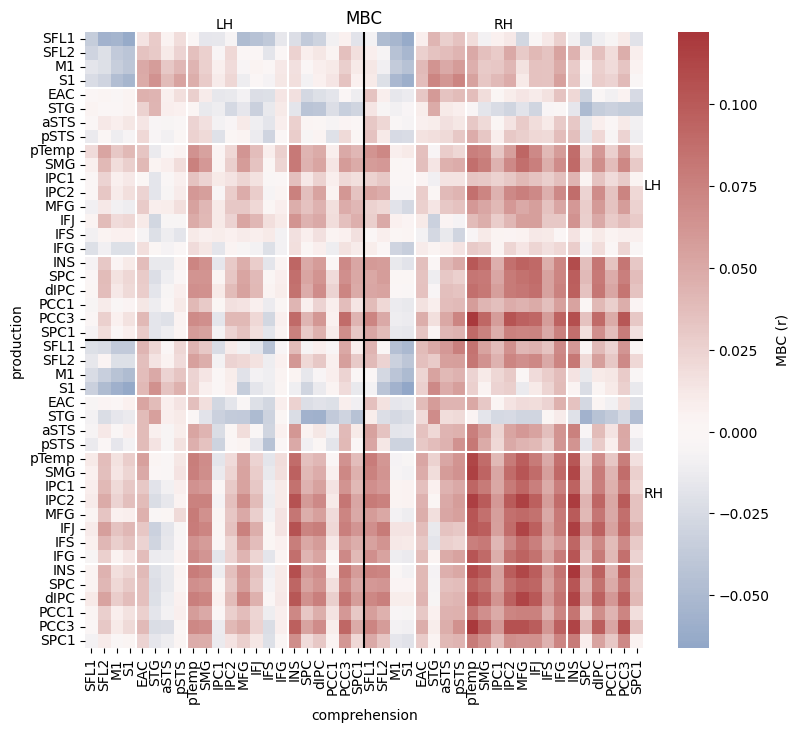

In [11]:
fig = plt.figure(figsize=(9, 8))  # dpi=300)

labels = [lb.split('_')[-1] for lb in atlas.labels]
ax = sns.heatmap(
    C,
    # vmin=.05,
    # vmax=.15,
    cmap="vlag",
    center=0,
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="MBC (r)"),
)

for i in [4, 8, 16]:
    ax.axvline(i, c="white")
    ax.axhline(i, c="white")
    ax.axvline(22 + i, c="white")
    ax.axhline(22 + i, c="white")
ax.axvline(22, c="black")
ax.axhline(22, c="black")

ax.set_title("MBC")
ax.set_xlabel("comprehension")
ax.set_ylabel("production")

ax.text(0.25, 1, "LH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center",)
ax.text(0.75, 1, "RH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center",)
ax.text(1, 0.25, "RH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")
ax.text(1, 0.75, "LH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")

fig.patch.set_alpha(0.0)
fig.show()

In [27]:
hemis = [lb.split("_")[0] for lb in atlas.labels]
networks = [lb.split("_")[1] for lb in atlas.labels]
rois = [lb.split("_")[2] for lb in atlas.labels]

In [54]:
def make_symmetric(matrix: np.ndarray) -> np.ndarray:
    du = np.triu(matrix, 0)
    dl = np.tril(matrix, 0)
    dn = (du + dl.T) / 2
    dn += dn.T
    np.fill_diagonal(dn, matrix.diagonal())
    return dn

(44, 44) (44, 44) (44, 44)


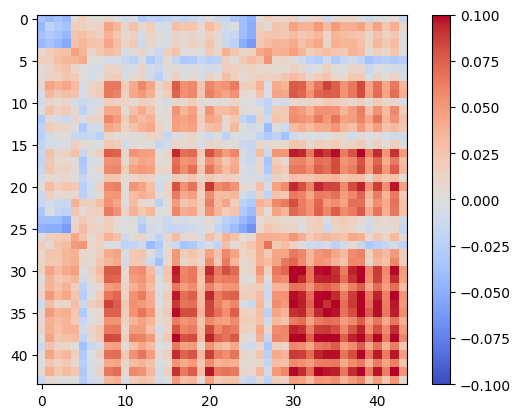

In [53]:
# plt.imshow(C, cmap='coolwarm', vmin=-.1, vmax=.1)
plt.imshow(make_symmetric(C), cmap='coolwarm', vmin=-.1, vmax=.1)
plt.colorbar()

In [89]:
d_euc_sym = 1 - make_symmetric(C)

mds = MDS(n_components=2, metric=not True, dissimilarity="precomputed")
newX = mds.fit_transform(d_euc_sym)
newX.shape

(44, 2)

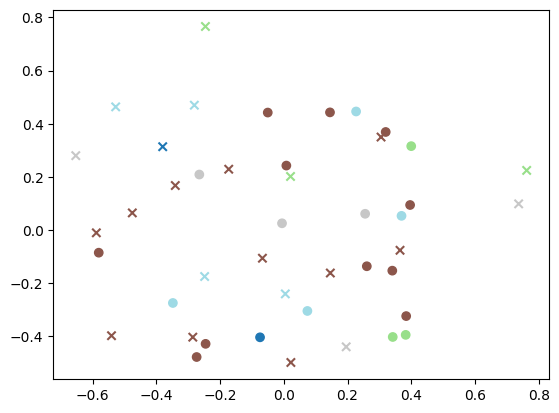

In [90]:
fig, ax = plt.subplots()

colors = LabelEncoder().fit_transform(networks)
# ax.scatter(newX[:, 0], newX[:, 1], marker="o", c=colors)
cmap = 'tab20'
ax.scatter(newX[:22, 0], newX[:22, 1], marker="o", c=colors[:22], cmap=cmap)
ax.scatter(newX[22:, 0], newX[22:, 1], marker="x", c=colors[22:], cmap=cmap)

fig.show()

In [ ]:
values = atlas.parc_to_vox(C.diagonal())
fig = plot.surface_plot(values, vmin=0, cmap='inferno', atlas=atlas, title='diagonal')

In [ ]:
import scipy.cluster.hierarchy as hc
linkage = hc.linkage(C, method='ward')

In [ ]:
df = pd.DataFrame(C, columns=atlas.labels, index=atlas.labels)

In [ ]:
g = sns.clustermap(df, # center=0, cmap="inferno",
                   row_linkage=linkage, col_linkage=linkage,
                #    row_colors=network_colors, col_colors=network_colors,
                   xticklabels=True, yticklabels=True,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.5,
                   figsize=(9, 10),
                   )
g.ax_row_dendrogram.remove()

# Figure 4 - lagged MBc

In [ ]:
roi_labels = atlas.labels

top down

In [ ]:
# colors = plt.get_cmap('tab20b').colors[-4:]
colors = plt.get_cmap("Dark2").colors[:4]

In [ ]:
linestyles = ["solid", "dotted", "dashed", "dashdot"]
linestyles = ["-"] * 4

In [ ]:
roi_labels[:21]

In [ ]:
comp_rois = ["RH_Lang_STG", "RH_Lang_MFG", "RH_Lang_IFG", "RH_Lang_pTemp", "RH_DMN_vPCC"]
prod_rois = ["RH_MOT_M1", "RH_Lang_MFG", "RH_Lang_IFG", "RH_Lang_pTemp", "RH_DMN_vPCC"]

xaxis = lags  # * 1.5

fig, axes = plt.subplots(
    1, len(comp_rois), figsize=(12, 3), sharey=True, layout="constrained"
)

for i, comp_roi in enumerate(comp_rois):
    ax = axes[i]
    ax.axvline(0, c="k")

    lines = []
    for prod_roi, color, linestyle in zip(prod_rois, colors, linestyles):
        i = roi_labels.index(comp_roi)
        j = roi_labels.index(prod_roi)
        values = mbc_scores[:, j, i]
        (ln,) = ax.plot(xaxis, values, c=color, ls=linestyle)
        lines.append(ln)

    ax.set_xticks(xaxis)
    ax.set(xlabel="lag (s)")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Style the grid.
    ax.set_facecolor("#EBEBEB")
    ax.grid(which="major", color="white", linewidth=1.2)
    ax.grid(which="minor", color="white", linewidth=0.6)
    ax.minorticks_on()
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax.set_xticks(xaxis[::2])
    ax.set_xticklabels((xaxis[::2] * 1.5).astype(int))

    # ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center",)
    # ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center",)
    ax.set_title(comp_roi, fontsize=10)

# axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_ylabel("MB-Conn (r)")
fig.suptitle("Comprehension ROIs")
fig.legend(
    lines,
    prod_rois,
    loc="outside lower center",
    ncols=len(prod_rois),
    title="Production ROIs",
)
fig.show()

middle groud

In [ ]:
prod_rois = {
    "low": ["RH_SM", "RH_EAC"],
    "lang1": ["RH_PostTemp", "RH_AntTemp"],
    "lang2": ["RH_MFG", "RH_IFG", "RH_IFGorb"],
    "dmn": ["RH_LatPar", "RH_dPCC", "RH_vPCC"],
}

comp_roi = "RH_LatPar"

xaxis = lags  # * 1.5

fig, axes = plt.subplots(
    1, len(prod_rois), figsize=(12, 4.2), sharey=True, layout="constrained"
)

for i, prod_group in enumerate(prod_rois):
    ax = axes[i]
    ax.axvline(0, c="k")

    lines = []
    for prod_roi, color, linestyle in zip(prod_rois[prod_group], colors, linestyles):
        i = roi_labels.index(comp_roi)
        j = roi_labels.index(prod_roi)
        values = mbc_roi_scores[:, j, i]
        (ln,) = ax.plot(xaxis, values, c=color, ls=linestyle)
        lines.append(ln)

    ax.set_xticks(xaxis)
    ax.set(xlabel="lag (s)")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Style the grid.
    ax.set_facecolor("#EBEBEB")
    ax.grid(which="major", color="white", linewidth=1.2)
    ax.grid(which="minor", color="white", linewidth=0.6)
    ax.minorticks_on()
    ax.tick_params(which="minor", bottom=False, left=False)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax.set_xticks(xaxis[::2])
    ax.set_xticklabels((xaxis[::2] * 1.5).astype(int))

    ax.text(
        0.25,
        1,
        "speaker precedes",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="center",
    )
    ax.text(
        0.75,
        1,
        "listener precedes",
        transform=ax.transAxes,
        verticalalignment="top",
        horizontalalignment="center",
    )
    ax.set_title(prod_group, fontsize=10)

    ax.legend(lines, prod_rois[prod_group], loc="lower right")

# axes[0].set_ylim(0, axes[0].get_ylim()[1])
axes[0].set_ylabel("MB-Conn (r)")
fig.suptitle(f"listener {comp_roi}")
fig.show()

buttom up

In [ ]:
labels = [lb.lstrip("LRH_") for lb in atlas.labels]

ax = sns.heatmap(
    mbc_roi_scores.max(0),
    cmap="Reds",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="MBC (r)"),
)

ax.axvline(11, c="white")
ax.axhline(11, c="white")

# # ax.set_title('within subject')
# ax.set_title('between subjects euc')
# ax.set_xlabel('comprehension')
# ax.set_ylabel('production')

fig.patch.set_alpha(0.0)
fig.show()

In [ ]:
bestlags = mbc_roi_scores.argmax(0)  # - len(lags) / 2
bestlags.shape

In [ ]:
labels = [lb.lstrip("LRH_") for lb in atlas.labels]

ax = sns.heatmap(
    bestlags,
    #  vmin=-4, vmax=4,
    cmap="bwr",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="lag (TR)"),
)

ax.axvline(11, c="white")
ax.axhline(11, c="white")

# # ax.set_title('within subject')
# ax.set_title('between subjects euc')
# ax.set_xlabel('comprehension')
# ax.set_ylabel('production')

fig.patch.set_alpha(0.0)
fig.show()

In [ ]:
from scipy.signal import peak_widths

In [ ]:
fwhms = np.zeros((len(atlas), len(atlas)))
for i in range(len(atlas)):
    for j in range(len(atlas)):
        values = mbc_roi_scores[:, i, j]
        peak = values.argmax()
        fwhms[i, j], _, _, _ = peak_widths(values, [peak])

labels = [lb.lstrip("LRH_") for lb in atlas.labels]

ax = sns.heatmap(
    fwhms,
    cmap="magma",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="fwhm (TR)"),
)

ax.axvline(11, c="white")
ax.axhline(11, c="white")

# # ax.set_title('within subject')
# ax.set_title('between subjects euc')
# ax.set_xlabel('comprehension')
# ax.set_ylabel('production')

fig.patch.set_alpha(0.0)
fig.show()

In [ ]:
pairs = [
    ("RH_SM", "RH_EAC"),
    ("RH_EAC", "RH_EAC"),
    ("RH_IFG", "RH_EAC"),
    # ('RH_EAC', 'RH_AngG'),
]

# pairs = [
#     ('RH_PostTemp',  'RH_PostTemp'),
#     ('RH_IFG',  'RH_MFG'),
#     ('RH_LatPar', 'RH_PostTemp'),
#     ('RH_IFG',  'RH_PostTemp'),
# ]

fig, ax = plt.subplots()
ax.axvline(0, c="k")

xaxis = lags  # * 1.5

for roi1, roi2 in pairs:
    i = roi_labels.index(roi1)
    j = roi_labels.index(roi2)
    values = mbc_roi_scores[:, i, j]
    ax.plot(xaxis, values, marker="", label=f"{roi1}, {roi2}")

# values = mbc_roi_scores[:, 0, 1]
# plt.plot(xaxis, values, marker='.')

# values = mbc_roi_scores[:, roi_labels.index('LH_SM'), roi_labels.index('LH_SM')]
# plt.plot(xaxis, values, marker='.')

ax.set_xticks(xaxis)
ax.set(xlabel="lag (TR)", ylabel="MB-Conn (r)")

ax.set_facecolor("#EBEBEB")
# Remove border around plot.
# [ax.spines[side].set_visible(False) for side in ax.spines]
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)

# Style the grid.
ax.grid(which="major", color="white", linewidth=1.2)
ax.grid(which="minor", color="white", linewidth=0.6)
# Show the minor ticks and grid.
ax.minorticks_on()
# Now hide the minor ticks (but leave the gridlines).
ax.tick_params(which="minor", bottom=False, left=False)

ax.text(
    0.25,
    1.05,
    "speaker precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)
ax.text(
    0.75,
    1.05,
    "listener precedes",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="center",
)

# ax.set_xticklabels(rotation=90)


ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))

ax.legend(frameon=False)
fig.show()

# Figure 5 - prod/comp weight similarity

voxelwise

In [ ]:
# sim between prod and comp
weight_sim_within = []
weight_sim_between = []

respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prod = f["cv_weights_prod"][...].mean(0)
        weights_comp = f["cv_weights_comp"][...].mean(0)

    raw_corrs = correlation_score(weights_prod, weights_comp)
    weight_sim_within.append(raw_corrs)

    subB = subject.get_partner(sub)
    respath.update(sub=f"{subB:03d}")
    with h5py.File(respath, "r") as f:
        weights_compB = f["cv_weights_comp"][...].mean(0)
    raw_corrs = correlation_score(weights_prod, weights_compB)
    weight_sim_between.append(raw_corrs)

weight_sim_within = np.stack(weight_sim_within)
weight_sim_between = np.stack(weight_sim_between)
weight_sim_within.shape

In [ ]:
with h5py.File(f"cache/{modelname}/{cache}/weight-sim.hdf5", "w-") as f:
    f.create_dataset(name="weight_sim_within", data=weight_sim_within)
    f.create_dataset(name="weight_sim_between", data=weight_sim_between)

In [ ]:
with h5py.File(f"cache/{modelname}/{cache}/weight-sim.hdf5", "r") as f:
    weight_sim_within = f["weight_sim_within"][...]
    weight_sim_between = f["weight_sim_between"][...]

In [ ]:
vmax = None

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

values = weight_sim_between.mean(0)
plot.surface_plot(values, cmap="coolwarm", vmax=vmax, fig=fig, ax=axes[0], title="between weight sim")

values = weight_sim_within.mean(0)
plot.surface_plot(values, cmap="coolwarm", vmax=vmax, fig=fig, ax=axes[1], title="within weight sim")

fig.show()

In [ ]:
# # mean vs harmonic mean
# r = np.linspace(-1, 1, 100)
# amean = np.zeros((100, 100))
# hmean = np.zeros((100, 100))
# for i in range(100):
#     for j in range(100):
#         amean[i, j] = (r[i] + r[j]) / 2
#         hmean[i, j] = (2 * r[i] * r[j]) / (r[i] + r[j] + 1e-8)
# fig, axes = plt.subplots(1, 2)
# axes[0].matshow(amean, vmin=-1, vmax=1, cmap="bwr")
# axes[1].matshow(hmean, vmin=-1, vmax=1, cmap="bwr")
# fig.show()

## inter-roi

In [ ]:
# params = 'between_prod2comp'
params = 'within_prod2comp'
# params = 'within_comp2comp'
# params = 'within_prod2prod'

In [ ]:
atlas = catlas
distsC = np.zeros((len(atlas), len(atlas)), dtype=np.float32)

respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

def get_weights(sub, prod:bool, comp:bool):
    assert prod or comp
    respath.update(sub=f"{sub:03d}")
    
    outputs = ()
    with h5py.File(respath, "r") as f:
        if prod:
            outputs = (f["cv_weights_prod"][...].mean(0), )
        if comp:
            outputs += (f['cv_weights_comp'][...].mean(0), )
    if len(outputs) == 1:
        outputs = outputs[0]
    return outputs

for subA in tqdm(SUBS_STRANGERS):

    if params == 'between_prod2comp':
        subB = subject.get_partner(subA)
        values1 = get_weights(subA, prod=True, comp=False)
        values2 = get_weights(subB, prod=False, comp=True)
    elif params == 'within_prod2comp':
        values1, values2 = get_weights(subA, prod=True, comp=True)
    elif params == 'within_comp2comp':
        values1 = get_weights(subA, prod=False, comp=True)
        values2 = values1
    elif params == 'within_prod2prod':
        values1 = get_weights(subA, prod=True, comp=False)
        values2 = values1

    values1 = atlas.vox_to_parc(values1)
    values2 = atlas.vox_to_parc(values2)

    distsC += cdist(values1.T, values2.T, metric="correlation")

distsC /= len(SUBS_STRANGERS)
distsC.shape

In [ ]:
# save
outdir = f'cache/{modelname}/{cache}'
!mkdir -p $outdir
with h5py.File(f"{outdir}/xcorr-weights_{params}.hdf5", "w") as f:
    f.create_dataset(name="dists", data=distsC)
outdir, params

In [ ]:
!ls -l $outdir

In [ ]:
# load
outdir = f'cache/{modelname}/{cache}'
with h5py.File(f"{outdir}/xcorr-weights_{params}.hdf5", "r") as f:
    distsC = f["dists"][...]
distsC.shape

In [ ]:
vmax = np.triu(1 - distsC, 1).max()
vmax

In [ ]:
fig = plt.figure(figsize=(8, 7))  # dpi=300)

labels = [lb.split('_')[-1] for lb in atlas.labels]
ax = sns.heatmap(
    1 - distsC,
    center=0, vmax=vmax, cmap='vlag', 
    # vmin = 0, vmax = vmax, cmap="Reds",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="weight sim (r)"),
)

for i in [5, 9, 15]:
    ax.axvline(i, c="white")
    ax.axhline(i, c="white")
    ax.axvline(21 + i, c="white")
    ax.axhline(21 + i, c="white")
ax.axvline(21, c="black")
ax.axhline(21, c="black")

ax.set_title(params)
ax.set_xlabel("comprehension")
ax.set_ylabel("production")

ax.text(0.25, 1, "LH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center")
ax.text(0.75, 1, "RH", transform=ax.transAxes, verticalalignment="bottom", horizontalalignment="center")
ax.text(1, 0.25, "RH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")
ax.text(1, 0.75, "LH", transform=ax.transAxes, verticalalignment="center", horizontalalignment="left")

fig.patch.set_alpha(0.0)
fig.show()

In [ ]:
# load
params = ['between_prod2comp', 'within_prod2comp', 'within_comp2comp', 'within_prod2prod']
outdir = f'cache/{modelname}/{cache}'

dists = []
for param in params:
    with h5py.File(f"{outdir}/xcorr-weights_{param}.hdf5", "r") as f:
        dists.append(1 - f["dists"][...])
len(dists)

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, layout='constrained')

# labels = [lb.split('_')[-1] for lb in atlas.labels]
for param, D, ax in zip(params, dists, axes):
    Dsub = D[21:, 21:]
    vmax = Dsub[Dsub < .85].max()
    sns.heatmap(
        Dsub,
        center = 0,
        cmap='vlag',
        vmax = vmax,
        xticklabels=labels[:21],
        yticklabels=labels[:21],
        # cbar_kws=dict(label="weight sim (r)"),
        ax=ax,
        figure=fig,
    )

    ax.set_title(param)

    for i in [5, 9, 15]:
        ax.axvline(i, c="white")
        ax.axhline(i, c="white")
        ax.axvline(21 + i, c="white")
        ax.axhline(21 + i, c="white")

# ax.set_xlabel("comprehension")
# ax.set_ylabel("production")
fig.suptitle('RH to RH', fontsize=10)

fig.show()

# Figure X - cross encoding?

In [ ]:
# load black results

respath = Path(
    # root="encoding/black_to_conv",
    root="encoding/conv_to_black",
    sub="000",
    datatype="model-opt-7b_layer-23",
    ext=".hdf5",
)

blackconv_results = defaultdict(list)
for sub in SUBS_STRANGERS:
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        continue
    with h5py.File(respath, "r") as f:
        blackconv_results['story'].append(f["scores_story"][-1, :])
        blackconv_results['conv'].append(f["scores_conv"][-1, :])
        blackconv_results['prod'].append(f["scores_prod"][-1, :])
        blackconv_results['comp'].append(f["scores_comp"][-1, :])

In [ ]:
story_score = np.stack(blackconv_results['story'])
conv_scores = np.stack(blackconv_results['conv'])
prod_scores = np.stack(blackconv_results['prod'])
comp_scores = np.stack(blackconv_results['comp'])
conv_scores.shape

In [ ]:
plot.surface_plot(story_score.mean(0), vmin=0.0, vmax=0.08, cmap="hot");

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
plot.surface_plot(story_score.mean(0), fig=fig, vmin=0.0, atlas=None, ax=axes[0,0], cmap="hot", title="story")
plot.surface_plot(conv_scores.mean(0), fig=fig, vmin=0.3, atlas=None, ax=axes[0,1], cmap="hot", title="conv")
plot.surface_plot(prod_scores.mean(0), fig=fig, vmin=0.3, atlas=None, ax=axes[1,0], cmap="hot", title="prod")
plot.surface_plot(comp_scores.mean(0), fig=fig, vmin=0.3, atlas=None, ax=axes[1,1], cmap="hot", title="comp")
fig.show()

# behavior

## Load data

Load overall ratings

In [91]:
df_ratings_overall = pd.read_csv("mats/CONV_Postscan_Global.csv", index_col="ID")
df_ratings_overall.drop(["Unnamed: 0", "Group"], axis=1, inplace=True)
ids = SUBS_STRANGERS
df_ratings_overall = df_ratings_overall.loc[ids]
df_ratings_overall.head(10)

,speak_closeness,speak_enjoyed,speak_uncertain,speak_anxious,listen_closeness,listen_enjoyed,listen_learned,listen_paid_attention,overall_felt_similar,overall_become_friends,IOS,similarity_comp,enjoyment_comp,closeness_comp,negative_affect_comp
ID,,,,,,,,,,,,,,,
104,3,3,3,4,5,4,6,7,4,4,2,3.333333,3.5,4.0,3.5
105,4,7,3,4,4,7,5,7,5,6,5,5.333333,7.0,4.0,3.5
106,5,6,2,5,6,6,6,6,5,6,5,5.333333,6.0,5.5,3.5
107,2,5,3,4,5,5,6,6,5,4,3,4.000000,5.0,3.5,3.5
108,5,6,2,5,6,6,7,6,5,6,3,4.666667,6.0,5.5,3.5
111,6,6,2,5,6,7,7,7,6,6,3,5.000000,6.5,6.0,3.5
112,5,7,3,4,5,7,7,7,5,6,2,4.333333,7.0,5.0,3.5
114,6,6,6,6,6,7,7,6,6,6,5,5.666667,6.5,6.0,6.0
116,4,5,3,6,3,5,5,5,5,4,1,3.333333,5.0,3.5,4.5


get prompt-level ratings

In [92]:
df_ratings = pd.read_csv("mats/conv_postscan_run.csv", index_col=0)
df_ratings = (
    df_ratings.groupby(["subject", "run", "trial", "label"]).rating.mean().reset_index()
)
df_ratings = df_ratings.pivot(index=["subject", "run", "trial"], columns="label")
df_ratings = df_ratings.droplevel(0, axis=1)
df_ratings = df_ratings.reindex(
    columns=[
        "speak_close",
        "speak_enjoy",
        "speak_uncertain",
        "speak_anxious",
        "listen_close",
        "listen_enjoy",
        "listen_learned",
        "listen_paidattention",
    ]
)
df_ratings

label              speak_close  speak_enjoy  speak_uncertain  speak_anxious  \
subject run trial                                                             
4       1   1              1.0          1.0              1.0            4.0   
            4              4.0          4.0              4.0            6.0   
        2   2              2.0          4.0              4.0            4.0   
            3              4.0          4.0              4.0            4.0   
        3   2              4.0          4.0              4.0            4.0   
...                        ...          ...              ...            ...   
174     3   4              6.0          6.0              2.0            2.0   
        4   1              6.0          6.0              4.0            3.0   
            3              5.0          6.0              6.0            5.0   
        5   2              5.0          6.0              3.0            5.0   
            4              4.0          5.0              4.0            4.0   

label              listen_close  listen_enjoy  listen_learned  \
subject run trial                                               
4       1   1               1.0           1.0             1.0   
            4               4.0           4.0             4.0   
        2   2               5.0           5.0             5.0   
            3               4.0           4.0             4.0   
        3   2               4.0           4.0             4.0   
...                         ...           ...             ...   
174     3   4               7.0           7.0             7.0   
        4   1               6.0           6.0             6.0   
            3               6.0           6.0             6.0   
        5   2               6.0           5.0             5.0   
            4               6.0           5.0             5.0   

label              listen_paidattention  
subject run trial                        
4       1   1                       1.0  
            4                       4.0  
        2   2                       5.0  
            3                       4.0  
        3   2                       4.0  
...                                 ...  
174     3   4                       6.0  
        4   1                       6.0  
            3                       6.0  
        5   2                       6.0  
            4                       5.0  

[580 rows x 8 columns]

get LLM-based entropy and perplexity

In [13]:
dfs = []
# perplexity = exp( - 1/n sum (log p ))
for sub in CONVS_STRANGERS:
    df = subject.get_transcript(sub, modelname=modelname)
    df["true_prob"] = np.log(df["true_prob"])

    df["trial"] = ((df["trial"] - 1) % 4) + 1
    df.rename(
        columns={
            "speaker": "subject",
            "entropy": "self_entropy",
            "true_prob": "self_logp",
        },
        inplace=True,
    )
    df = df.groupby(["subject", "run", "trial"])[["self_entropy", "self_logp"]].mean()
    df2 = df.reset_index()
    df2.subject = [i + 100 if i < 100 else i - 100 for i in df2.subject.values]
    df2.set_index(["subject", "run", "trial"], inplace=True)
    df2.rename(
        columns={"self_entropy": "other_entropy", "self_logp": "other_logp"},
        inplace=True,
    )
    dfs.append(pd.concat((df, df2), axis=1))
df_llm_metrics = pd.concat(dfs)
df_llm_metrics

self_entropy  self_logp  other_entropy  other_logp
subject run trial                                                    
4       1   1          3.040250  -9.287051       2.922405   -9.737705
            4          2.598337  -9.765915       2.944651   -9.442375
        2   2          2.719944  -9.279158       2.742903   -9.452505
            3          2.577567  -9.813503       2.292847   -9.849290
        3   2          2.668654  -9.510879       2.598497   -9.460717
...                         ...        ...            ...         ...
174     3   4          2.453260  -9.595432       2.628445   -9.175252
        4   1          2.340441  -9.278392       2.828524   -9.461228
            3          2.345113  -9.115280       2.464163   -8.850501
        5   2          2.628316  -9.228703       2.604023   -9.143596
            4          2.701133  -9.480067       2.670774   -9.431624

[580 rows x 4 columns]

get LLM-based entropy and perplexity ( per sentence or trial)

In [ ]:
dfs = []
for sub in CONVS_STRANGERS:
    df = subject.get_transcript(sub, modelname=modelname)
    df.insert(0, "conv", sub)
    df["true_prob"] = np.log(df["true_prob"])
    df["trial"] = ((df["trial"] - 1) % 4) + 1

    df2 = df.groupby(["conv", "run", "trial", "speaker", "sentence", "word_idx"]).agg(
        {"word": "first", "entropy": "mean", "true_prob": "mean"}
    )
    # df3 = df2.groupby(['conv', 'run', 'trial', 'speaker', 'sentence']).agg({'word': lambda x: ' '.join(x), 'entropy': 'mean', 'true_prob': lambda x: np.exp(-np.mean(x))})
    df3 = df2.groupby(["conv", "run", "trial"]).agg(
        {
            "word": lambda x: " ".join(x),
            "entropy": "mean",
            "true_prob": lambda x: np.exp(-np.mean(x)),
        }
    )
    dfs.append(df3)

df_llm_metrics = pd.concat(dfs)
df_llm_metrics.sort_values("true_prob", inplace=True)
df_llm_metrics

 get number of words and such

In [16]:
dfs = []
for sub in CONVS_STRANGERS:
    df = subject.get_transcript(sub, modelname=modelname)

    df["trial"] = ((df["trial"] - 1) % 4) + 1
    df.rename(columns={"speaker": "subject", "word": "words_spoken"}, inplace=True)
    df = df.groupby(["subject", "run", "trial"]).words_spoken.count()

    df2 = df.reset_index()
    df2.rename(columns={"words_spoken": "words_heard"}, inplace=True)
    df2.subject = [i + 100 if i < 100 else i - 100 for i in df2.subject.values]
    df2.set_index(["subject", "run", "trial"], inplace=True)
    dfs.append(pd.concat((df, df2), axis=1))

df_wordcount = pd.concat(dfs)
df_wordcount

words_spoken  words_heard
subject run trial                           
4       1   1             221.0        336.0
            4             195.0        473.0
        2   2             284.0        372.0
            3             238.0        478.0
        3   2             370.0        349.0
...                         ...          ...
174     3   4             288.0        361.0
        4   1             378.0        339.0
            3             463.0        222.0
        5   2             367.0        330.0
            4             347.0        322.0

[580 rows x 2 columns]

load encoding results

In [95]:
# TODO verify flatten
atlas = glasser

sub_run_prod = all_scores_prod[:, :, -2, :]
sub_run_comp = all_scores_comp[:, :, -1, :]

sub_run_prod_rois = atlas.vox_to_parc(sub_run_prod)
sub_run_comp_rois = atlas.vox_to_parc(sub_run_comp)

df_enc = pd.DataFrame()
df_enc["subject"] = np.repeat(SUBS_STRANGERS, 5)
df_enc["run"] = np.tile(np.arange(1, 6), len(SUBS_STRANGERS))
df_enc["prod_med_score"] = np.median(sub_run_prod, axis=-1).flatten()
df_enc["comp_med_score"] = np.median(sub_run_comp, axis=-1).flatten()
df_enc["prod_roi_med_score"] = np.median(sub_run_prod_rois, axis=-1).flatten()
df_enc["comp_roi_med_score"] = np.median(sub_run_comp_rois, axis=-1).flatten()
df_enc.set_index(["subject", "run"], inplace=True)
df_enc

prod_med_score  comp_med_score  prod_roi_med_score  \
subject run                                                       
104     1      2.057823e-15    9.799306e-10            0.012091   
        2      1.258572e-06    1.205982e-12            0.022221   
        3      1.750939e-06    1.902137e-07            0.022032   
        4      8.044590e-07    6.248691e-06            0.023158   
        5      1.949619e-05    2.841685e-04            0.020702   
...                     ...             ...                 ...   
74      1      9.122577e-13    2.102699e-06            0.004998   
        2      6.689820e-11    1.406242e-06            0.011493   
        3      3.346857e-06    7.002333e-12            0.008768   
        4      1.588865e-08    8.657918e-14            0.012358   
        5      1.012127e-10    5.249333e-08            0.006656   

             comp_roi_med_score  
subject run                      
104     1              0.013452  
        2              0.020456  
        3              0.011370  
        4              0.029232  
        5              0.022402  
...                         ...  
74      1              0.020648  
        2              0.025126  
        3              0.008325  
        4              0.006708  
        5              0.019376  

[290 rows x 4 columns]

In [96]:
df_enc_roi = pd.DataFrame()
df_enc_roi["subject"] = np.repeat(SUBS_STRANGERS, 5)
df_enc_roi["run"] = np.tile(np.arange(1, 6), len(SUBS_STRANGERS))
for i, col in enumerate(atlas.labels):
    df_enc_roi["prod_" + col] = sub_run_prod_rois[..., i].flatten()
for i, col in enumerate(atlas.labels):
    df_enc_roi["comp_" + col] = sub_run_comp_rois[..., i].flatten()
df_enc_roi.set_index(["subject", "run"], inplace=True)
df_enc_roi

prod_L_V1  prod_L_MST  prod_L_V6  prod_L_V2  prod_L_V3  \
subject run                                                           
104     1     0.007956    0.002331  -0.000604   0.011672   0.012633   
        2     0.020396    0.003869   0.021347   0.023724   0.021245   
        3     0.016532    0.004360   0.012498   0.020977   0.016379   
        4     0.012082   -0.008739   0.000970   0.017129   0.012375   
        5     0.011749   -0.002938   0.016576   0.025608   0.019773   
...                ...         ...        ...        ...        ...   
74      1     0.008650    0.008219  -0.000073   0.004449   0.000822   
        2     0.010161    0.015856   0.013469   0.008075   0.001292   
        3     0.010826    0.007965   0.000477   0.012611   0.011511   
        4     0.005169    0.003117   0.019928   0.011020   0.006135   
        5     0.007272    0.020175   0.008993   0.006461   0.005716   

             prod_L_V4  prod_L_V8  prod_L_4  prod_L_3b  prod_L_FEF  ...  \
subject run                                                         ...   
104     1     0.007126  -0.013394  0.049406   0.039362    0.001410  ...   
        2     0.013429   0.027210  0.087051   0.077515    0.012674  ...   
        3     0.026977   0.019879  0.063878   0.033255    0.041511  ...   
        4     0.012222   0.020673  0.051322   0.021912    0.034557  ...   
        5     0.014252   0.013753  0.029520   0.024461   -0.009581  ...   
...                ...        ...       ...        ...         ...  ...   
74      1     0.004225  -0.000356  0.029864   0.005910    0.015861  ...   
        2     0.004781  -0.007259  0.034457   0.011624    0.010003  ...   
        3    -0.000132  -0.005321  0.026794   0.006201   -0.003456  ...   
        4    -0.004456  -0.020346  0.029318   0.009165    0.012062  ...   
        5     0.001304  -0.006437  0.008709   0.009222   -0.008599  ...   

             comp_R_p47r  comp_R_TGv  comp_R_MBelt  comp_R_LBelt  comp_R_A4  \
subject run                                                                   
104     1       0.020539    0.010669     -0.006975      0.001726   0.034188   
        2       0.007206    0.016756     -0.000181      0.006508   0.029306   
        3       0.047119    0.013912     -0.017293      0.006978   0.012329   
        4       0.022753    0.018117      0.001799      0.002356   0.015598   
        5       0.051146   -0.004570     -0.006414      0.027212   0.025209   
...                  ...         ...           ...           ...        ...   
74      1       0.057821    0.008982      0.054475      0.107616   0.040404   
        2       0.031970    0.003279     -0.005302      0.149928   0.089937   
        3       0.009906    0.003622      0.075819      0.171070   0.073932   
        4       0.020523    0.000186      0.046383      0.092379   0.057012   
        5       0.036142    0.011758      0.098151      0.178073   0.083753   

             comp_R_STSva  comp_R_TE1m  comp_R_PI  comp_R_a32pr  comp_R_p24  
subject run                                                                  
104     1        0.008954     0.024257  -0.003092      0.012831   -0.011187  
        2        0.039811     0.046460   0.001609      0.011682   -0.012762  
        3       -0.013048     0.007310  -0.003522      0.013518   -0.006195  
        4        0.043249     0.018364  -0.002023      0.028455    0.028382  
        5        0.023090    -0.006319   0.015077      0.047161    0.017739  
...                   ...          ...        ...           ...         ...  
74      1        0.037964     0.014907   0.010337      0.006065    0.020835  
        2        0.024051     0.016247  -0.000218      0.036318    0.042372  
        3       -0.001622     0.000282   0.000340      0.014934    0.036154  
        4       -0.007472     0.002091   0.010871      0.013202   -0.009249  
        5        0.019890    -0.011341   0.004219      0.011973    0.024809  

[290 rows x 720 columns]

load mbc scores

In [ ]:
df_mbc = pd.DataFrame()
df_mbc["subject"] = np.repeat(SUBS_STRANGERS, 5)
df_mbc["run"] = np.tile(np.arange(1, 6), len(SUBS_STRANGERS))
df_mbc["prod_med_score"] = np.median(sub_run_prod, axis=-1).flatten()  # NOTE flatten
df_mbc["comp_med_score"] = np.median(sub_run_comp, axis=-1).flatten()
df_mbc["prod_roi_med_score"] = np.median(sub_run_prod_rois, axis=-1).flatten()
df_mbc["comp_roi_med_score"] = np.median(sub_run_comp_rois, axis=-1).flatten()
df_mbc.set_index(["subject", "run"], inplace=True)
df_mbc

In [ ]:
# sub_mbc_prod = np.stack(mbc_scores["prod"])
# sub_mbc_comp = np.stack(mbc_scores["comp"])
sub_mbc_prod.shape

In [ ]:
soc_atlas = Atlas.load('ns_social_glasser')

In [ ]:
sub_mbc_prod_rois = soc_atlas.vox_to_parc(sub_mbc_prod)
sub_mbc_comp_rois = soc_atlas.vox_to_parc(sub_mbc_comp)
sub_mbc_rois = (sub_mbc_prod_rois + sub_mbc_comp_rois ) / 2

In [ ]:
df_mbc_roi = pd.DataFrame()
df_mbc_roi["subject"] = np.repeat(SUBS_STRANGERS, 5)
df_mbc_roi["run"] = np.tile(np.arange(1, 6), len(SUBS_STRANGERS))
for i, col in enumerate(soc_atlas.labels):
    df_mbc_roi[col] = sub_mbc_rois[..., i].flatten()
# for i, col in enumerate(soc_atlas.labels):
#     df_mbc_roi["prod_" + col] = sub_mbc_prod_rois[..., i].flatten()
# for i, col in enumerate(soc_atlas.labels):
#     df_mbc_roi["comp_" + col] = sub_mbc_comp_rois[..., i].flatten()
df_mbc_roi.set_index(["subject", "run"], inplace=True)
df_mbc_roi

In [ ]:
joined = df_mbc_roi.mean(1).to_frame('mbc_soc').join(df_ratings)
joined.corr().iloc[0, 1:]

In [ ]:
sns.relplot(joined, x='listen_close', y='mbc_soc')

load framewise displacement confound

In [ ]:
confpath = Path(
    root="data/derivatives/fmriprep",
    datatype="func",
    sub="000",
    ses="1",
    task="Conv",
    run="0",
    desc="confounds",
    suffix="timeseries",
    ext=".tsv",
)

records = []
black_records = []
for sub in tqdm(SUBS_STRANGERS):
    confpath.update(sub=f"{sub:03d}")

    run2trial = subject.get_trials(sub)
    _, in_prod = subject.get_button_presses(sub)
    in_prod = in_prod.astype(bool)

    for run in RUNS:
        confpath.update(run=run)

        run_confs = pd.read_csv(
            confpath, sep="\t", usecols=["framewise_displacement"]
        ).to_numpy()
        for j, trial in enumerate(run2trial[run]):
            trial_slice = RUN_TRIAL_SLICE[trial]
            fwd = run_confs[trial_slice]

            start = (run - 1) * 240 + (j * 120)
            inp = in_prod[start : start + 120]
            records.append(
                (sub, run, trial, fwd.mean(), fwd[inp].mean(), fwd[~inp].mean())
            )

    black_confpath = confpath.copy().update(task="Black", run=1)
    if black_confpath.isfile():
        black_confs = pd.read_csv(
            black_confpath, sep="\t", usecols=["framewise_displacement"]
        ).to_numpy()
        black_records.append((sub, black_confs[8:-8].mean()))

df_displacement = pd.DataFrame(
    records, columns=["subject", "run", "trial", "fwd", "fwd_prod", "fwd_comp"]
)
df_displacement["diff"] = df_displacement.fwd_prod - df_displacement.fwd_comp
df_displacement.sort_values("diff").head()

In [ ]:
df_disp_black = pd.DataFrame(black_records, columns=["subject", "black_fwd"])
df_disp_black.set_index("subject", inplace=True)

## compare motion and its correlates

In [ ]:
df_disp_black = df_disp_black.join(df_displacement.groupby("subject").mean())

fig, ax = plt.subplots()
sns.scatterplot(df_disp_black, x="fwd_comp", y="black_fwd", ax=ax)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
ax.set(xlim=(0, 0.5), ylim=(0, 0.5))
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(
    [df_disp_black["fwd_comp"], df_disp_black["black_fwd"]], color="grey", linewidth=0.5
)
sns.stripplot(
    df_disp_black[["fwd_comp", "black_fwd"]], size=4, color=".3", ax=ax, jitter=False
)
sns.violinplot(df_disp_black[["fwd_comp", "black_fwd"]], ax=ax, alpha=0.2)
ax.set_ylim(0, 0.6)
ax.set_xlim(-0.5, 1.5)
fig.show()

In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(df_displacement, x="fwd_prod", y="fwd_comp", hue="diff", ax=ax)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
ax.set(xlim=(0, 1), ylim=(0, 1))
fig.show()

In [ ]:
df_enc_fwd = df_enc.join(df_displacement.set_index(["subject", "run"]))
df_enc_fwd.dropna(subset="diff", inplace=True)
df_enc_fwd.corr("spearman")

In [ ]:
print(spearmanr(df_enc_fwd["prod_med_score"].values, df_enc_fwd["fwd_prod"].values))
print(spearmanr(df_enc_fwd["comp_med_score"].values, df_enc_fwd["fwd_comp"].values))

fig, ax = plt.subplots()
g = sns.scatterplot(df_enc_fwd, x="fwd_prod", y="prod_med_score", ax=ax, color="blue")
g = sns.scatterplot(df_enc_fwd, x="fwd_comp", y="comp_med_score", ax=ax, color="red")
fig.show()

In [ ]:
df2 = df_wordcount.reset_index().groupby(["subject", "run"]).sum()
df_enc_wrd = df_enc.join(df2)
df_enc_wrd.corr("spearman").iloc[:-3, -2:]

In [ ]:
ax = sns.scatterplot(df_enc_wrd, x="words_spoken", y="prod_med_score")
ax.set_yscale("log")

In [ ]:
ax = sns.scatterplot(df_enc_wrd, x="words_heard", y="comp_med_score")
ax.set_yscale("log")

## rating agreement

In [ ]:
df1 = df_ratings.reset_index()
df1["conv"] = df1.subject.apply(lambda x: int(subject.get_conv(x)))
df1

In [ ]:
diffs = []
for name, group in df1.groupby(["conv", "run", "trial"]):
    dft = group.diff().iloc[-1].abs()
    dft["subject"] = int(name[0])
    diffs.append(dft)
df2 = pd.concat(diffs, axis=1).T
df2.drop(columns=["run", "trial", "conv"], inplace=True)
df3 = df2.groupby("subject").mean(0)
df2

In [ ]:
colors = [BLU] * 4 + [ORG] * 4

fig, ax = plt.subplots()
sns.boxplot(df3, ax=ax, whis=[0, 100], palette=colors)  # , saturation=.3)
sns.stripplot(df3, size=4, color=".3", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(ylabel="difference in ratings (likert)", ylim=(0, 4), xlabel=None)
fig.show()

In [ ]:
ttest_1samp(df3.to_numpy(), axis=0, popmean=2, alternative="greater")

## just entropy

In [ ]:
df1 = df_llm_metrics.reset_index()
df1["self_logp"] = np.exp(-df1.self_logp)
df1["other_logp"] = np.exp(-df1.other_logp)
df1 = df1[df1.subject < 100]  # just keep half
df1.dropna(inplace=True)
df1

In [ ]:
df1.corr().iloc[3:, -4:]

In [ ]:
xcol, ycol = "self_entropy", "other_entropy"
r, p = stats.pearsonr(df1[xcol].values, df1[ycol].values)

fig, ax = plt.subplots(figsize=(5, 5))
# sns.regplot(df1, x=xcol, y=ycol, ax=ax)
sns.scatterplot(df1, x=xcol, y=ycol, ax=ax)
# ax.scatter(df1[xcol], df1[ycol])
ax.set(xlabel="sub-A entropy", ylabel="sub-B entropy")
ax.text(
    0.05,
    1,
    "N={}\nr={:.2f}\np={:.2g}".format(len(df1), r, p),
    transform=ax.transAxes,
    verticalalignment="top",
)
sns.despine(fig)
fig.show()

## just encoding

In [ ]:
df1 = df_enc.reset_index()
df1["conv"] = df1.subject.apply(lambda x: int(subject.get_conv(x)))
df1

In [ ]:
conv_scoresA = []
conv_scoresB = []
for name, group in df1[
    ["conv", "run", "prod_roi_med_score", "comp_roi_med_score"]
].groupby(["conv", "run"]):
    conv_scoresA.append(group["prod_roi_med_score"].iloc[0])
    conv_scoresB.append(group["comp_roi_med_score"].iloc[1])
    conv_scoresA.append(group["prod_roi_med_score"].iloc[1])
    conv_scoresB.append(group["comp_roi_med_score"].iloc[0])

In [ ]:
print(pearsonr(conv_scoresA, conv_scoresB))
print(spearmanr(conv_scoresA, conv_scoresB))

In [ ]:
sns.relplot(x=conv_scoresA, y=conv_scoresB)

## PLS

In [135]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score

### overall

In [150]:
df1 = df_enc_roi.groupby('subject').mean()
X = stats.zscore(np.arctanh(df1.to_numpy()))
X.shape

(58, 720)

In [138]:
overall_comps = df_ratings_overall.iloc[:, -4:]

In [158]:
for i, col in enumerate(overall_comps.columns):
    y = overall_comps[col].to_numpy()
    for n_comps in [2, 5, 10, 20, 50]:
        pls = PLSRegression(n_components=n_comps)
        scores = cross_val_score(pls, X, y)
        print(col, n_comps, scores.mean())

similarity_comp 2 -0.7644057582935576
similarity_comp 5 -0.5984549952228949
similarity_comp 10 -0.5435082630834546
similarity_comp 20 -0.5431744240740276
similarity_comp 50 -0.5431748441745411
enjoyment_comp 2 -0.5301254869858472
enjoyment_comp 5 -0.780778339833148
enjoyment_comp 10 -0.6961753061622167
enjoyment_comp 20 -0.696451677538844
enjoyment_comp 50 -0.6964516123601424
closeness_comp 2 -0.19554360431825643
closeness_comp 5 -0.20981421195338656
closeness_comp 10 -0.1900715591660659
closeness_comp 20 -0.19004017965717285
closeness_comp 50 -0.1917611930726205
negative_affect_comp 2 -0.5585991180794102
negative_affect_comp 5 -0.5610359860823498
negative_affect_comp 10 -0.5776273599290809
negative_affect_comp 20 -0.5777313913704434
negative_affect_comp 50 -0.5777316675910902


### prompt-level

In [98]:
df1 = df_ratings.groupby(["subject", "run"]).mean()
df2 = df_enc_roi
df3 = pd.concat((df1, df2), axis=1)
df3

speak_close  speak_enjoy  speak_uncertain  speak_anxious  \
subject run                                                             
4       1            2.5          2.5              2.5            5.0   
        2            3.0          4.0              4.0            4.0   
        3            5.5          5.5              3.5            3.5   
        4            4.0          4.5              4.0            3.5   
        5            3.0          3.5              4.0            4.0   
...                  ...          ...              ...            ...   
174     1            6.0          5.5              3.5            3.0   
        2            5.0          5.0              5.0            4.0   
        3            6.0          6.0              3.0            2.5   
        4            5.5          6.0              5.0            4.0   
        5            4.5          5.5              3.5            4.5   

             listen_close  listen_enjoy  listen_learned  listen_paidattention  \
subject run                                                                     
4       1             2.5           2.5             2.5                   2.5   
        2             4.5           4.5             4.5                   4.5   
        3             5.5           5.5             5.5                   5.5   
        4             5.5           4.5             4.5                   5.5   
        5             4.0           4.0             4.0                   4.0   
...                   ...           ...             ...                   ...   
174     1             6.0           6.0             6.5                   6.0   
        2             4.5           5.0             5.0                   6.0   
        3             6.5           6.5             6.5                   6.0   
        4             6.0           6.0             6.0                   6.0   
        5             6.0           5.0             5.0                   5.5   

             prod_L_V1  prod_L_MST  ...  comp_R_p47r  comp_R_TGv  \
subject run                         ...                            
4       1     0.064102    0.057570  ...    -0.001426   -0.004419   
        2     0.067553    0.040186  ...     0.006176    0.013931   
        3     0.032969    0.056842  ...     0.033387    0.035913   
        4     0.050867    0.028225  ...     0.010163    0.014633   
        5     0.051745    0.057926  ...     0.033469    0.009107   
...                ...         ...  ...          ...         ...   
174     1     0.045251    0.071227  ...     0.008587   -0.000042   
        2     0.045957    0.066824  ...     0.011982    0.016621   
        3     0.036822    0.071208  ...     0.007942    0.000205   
        4     0.044253    0.038177  ...     0.012770   -0.025340   
        5     0.040249    0.080133  ...    -0.001617   -0.001740   

             comp_R_MBelt  comp_R_LBelt  comp_R_A4  comp_R_STSva  comp_R_TE1m  \
subject run                                                                     
4       1        0.031431      0.014526   0.065284      0.029522     0.004696   
        2        0.021233     -0.000142   0.027445      0.036994     0.021004   
        3        0.109409      0.093639   0.117220      0.049757     0.017934   
        4        0.063975      0.051950   0.023573      0.031922     0.028058   
        5        0.017554      0.002907   0.038983      0.026641     0.039570   
...                   ...           ...        ...           ...          ...   
174     1        0.006827      0.009665   0.045611      0.069638    -0.015295   
        2        0.021795      0.007082   0.021139      0.056612     0.004521   
        3        0.004559      0.003382   0.033830      0.038161    -0.012649   
        4        0.016554      0.029512   0.037445      0.060298    -0.011055   
        5        0.022059     -0.036891   0.013868      0.054464     0.011499   

             comp_R_PI  comp_R_a32pr  comp_R_p24  
subject run        

In [104]:
df2.iloc[:, :360]

prod_L_V1  prod_L_MST  prod_L_V6  prod_L_V2  prod_L_V3  \
subject run                                                           
104     1     0.007956    0.002331  -0.000604   0.011672   0.012633   
        2     0.020396    0.003869   0.021347   0.023724   0.021245   
        3     0.016532    0.004360   0.012498   0.020977   0.016379   
        4     0.012082   -0.008739   0.000970   0.017129   0.012375   
        5     0.011749   -0.002938   0.016576   0.025608   0.019773   
...                ...         ...        ...        ...        ...   
74      1     0.008650    0.008219  -0.000073   0.004449   0.000822   
        2     0.010161    0.015856   0.013469   0.008075   0.001292   
        3     0.010826    0.007965   0.000477   0.012611   0.011511   
        4     0.005169    0.003117   0.019928   0.011020   0.006135   
        5     0.007272    0.020175   0.008993   0.006461   0.005716   

             prod_L_V4  prod_L_V8  prod_L_4  prod_L_3b  prod_L_FEF  ...  \
subject run                                                         ...   
104     1     0.007126  -0.013394  0.049406   0.039362    0.001410  ...   
        2     0.013429   0.027210  0.087051   0.077515    0.012674  ...   
        3     0.026977   0.019879  0.063878   0.033255    0.041511  ...   
        4     0.012222   0.020673  0.051322   0.021912    0.034557  ...   
        5     0.014252   0.013753  0.029520   0.024461   -0.009581  ...   
...                ...        ...       ...        ...         ...  ...   
74      1     0.004225  -0.000356  0.029864   0.005910    0.015861  ...   
        2     0.004781  -0.007259  0.034457   0.011624    0.010003  ...   
        3    -0.000132  -0.005321  0.026794   0.006201   -0.003456  ...   
        4    -0.004456  -0.020346  0.029318   0.009165    0.012062  ...   
        5     0.001304  -0.006437  0.008709   0.009222   -0.008599  ...   

             prod_R_p47r  prod_R_TGv  prod_R_MBelt  prod_R_LBelt  prod_R_A4  \
subject run                                                                   
104     1       0.024563    0.017352      0.007760     -0.000006   0.010099   
        2       0.036763    0.032219      0.019360      0.018319   0.009071   
        3       0.062484    0.015836      0.022016      0.022643   0.009745   
        4       0.071064   -0.008934      0.011826      0.044372  -0.009677   
        5       0.040113    0.023556      0.022164      0.015349   0.008731   
...                  ...         ...           ...           ...        ...   
74      1       0.030329    0.006115     -0.003668     -0.000543   0.004643   
        2       0.077665   -0.010236     -0.013022     -0.062712  -0.009744   
        3       0.030004   -0.014303      0.000382      0.001085   0.005867   
        4       0.077629    0.002470     -0.010969      0.007208   0.000049   
        5       0.063830    0.002186     -0.004776     -0.005348  -0.000817   

             prod_R_STSva  prod_R_TE1m  prod_R_PI  prod_R_a32pr  prod_R_p24  
subject run                                                                  
104     1        0.000019     0.038743   0.004683      0.015221    0.035288  
        2        0.038461     0.034291   0.008864      0.030108    0.022493  
        3        0.032110     0.023208  -0.000743      0.062619    0.068668  
        4        0.037967     0.040734   0.032339      0.045676    0.084093  
        5        0.041758     0.040766   0.039385      0.032608    0.055511  
...                   ...          ...        ...           ...         ...  
74      1        0.031979     0.003352   0.009989     -0.016489   -0.024243  
        2        0.030352     0.020970   0.008941      0.009882    0.037902  
        3        0.013656     0.008956   0.011152      0.010248    0.040083  
        4        0.042999     0.013073   0.006589      0.028118    0.033872  
        5        0.034772    -0.007914  -0.009027      0.014990    0.042680  

[290 rows x 360 columns]

In [105]:
Xprod = df2.iloc[:, :360].to_numpy()
Xcomp = df2.iloc[:, 360:].to_numpy()
Y = df1.to_numpy()
X.shape, Y.shape

((290, 720), (290, 8))

In [106]:
X = stats.zscore(np.arctanh(Xcomp))

In [122]:
y = stats.zscore(df1['listen_learned'].to_numpy())

In [127]:
from sklearn.model_selection import GroupKFold, KFold, ShuffleSplit
# see https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
groups = df3.index.get_level_values('subject').to_numpy() % 100
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(X, Y, groups)
print(group_kfold)

GroupKFold(n_splits=5)


In [128]:
for i, (train_index, test_index) in enumerate(group_kfold.split(X, Y, groups)):
    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}, group={groups[train_index]}")
    # print(f"  Test:  index={test_index}, group={groups[test_index]}")

    pls = PLSRegression(n_components=2)
    pls.fit(X[train_index], y[train_index])
    print(i, pls.score(X[test_index], y[test_index]))
    # print(i, correlation_score(pls.predict(X[test_index]).squeeze(), y[test_index]))

0 -0.1394991048355716
1 -0.15816294757153626
2 -0.11211107618310678
3 -0.24942824294543842
4 -0.2801899071124241


## ratings and brain score

In [22]:
df1 = df_ratings.groupby(["subject", "run"]).mean()  # average across trials
df2 = df_enc
df3 = pd.concat((df1, df2), axis=1)
df3

speak_close  speak_enjoy  speak_uncertain  speak_anxious  \
subject run                                                             
4       1            2.5          2.5              2.5            5.0   
        2            3.0          4.0              4.0            4.0   
        3            5.5          5.5              3.5            3.5   
        4            4.0          4.5              4.0            3.5   
        5            3.0          3.5              4.0            4.0   
...                  ...          ...              ...            ...   
174     1            6.0          5.5              3.5            3.0   
        2            5.0          5.0              5.0            4.0   
        3            6.0          6.0              3.0            2.5   
        4            5.5          6.0              5.0            4.0   
        5            4.5          5.5              3.5            4.5   

             listen_close  listen_enjoy  listen_learned  listen_paidattention  \
subject run                                                                     
4       1             2.5           2.5             2.5                   2.5   
        2             4.5           4.5             4.5                   4.5   
        3             5.5           5.5             5.5                   5.5   
        4             5.5           4.5             4.5                   5.5   
        5             4.0           4.0             4.0                   4.0   
...                   ...           ...             ...                   ...   
174     1             6.0           6.0             6.5                   6.0   
        2             4.5           5.0             5.0                   6.0   
        3             6.5           6.5             6.5                   6.0   
        4             6.0           6.0             6.0                   6.0   
        5             6.0           5.0             5.0                   5.5   

             prod_med_score  comp_med_score  prod_roi_med_score  \
subject run                                                       
4       1      3.627049e-05    8.532226e-09            0.068394   
        2      9.123198e-07    5.073472e-06            0.055417   
        3      3.269530e-04    4.697978e-10            0.038667   
        4      1.061224e-05    4.278827e-08            0.045465   
        5      3.360041e-03    2.917116e-07            0.067471   
...                     ...             ...                 ...   
174     1      3.670901e-04    1.946281e-07            0.072861   
        2      5.439862e-03    2.990790e-08            0.102895   
        3      1.088499e-03    0.000000e+00            0.095220   
        4      1.448173e-02    1.397927e-10            0.077509   
        5      2.017600e-03    2.681177e-09            0.078355   

             comp_roi_med_score  
subject run                      
4       1              0.031460  
        2              0.017750  
        3              0.026270  
        4              0.019788  
        5              0.034028  
...                         ...  
174     1              0.039781  
        2              0.025752  
        3              0.028561  
        4              0.037363  
        5              0.023850  

[290 rows x 12 columns]

In [24]:
df3.corr().iloc[:-4, -4:]

,prod_med_score,comp_med_score,prod_roi_med_score,comp_roi_med_score
speak_close,-0.008016,0.008677,-0.027082,-0.062838
speak_enjoy,-0.094898,0.008505,-0.090953,-0.009075
speak_uncertain,-0.002556,-0.015168,-0.067538,-0.001465
speak_anxious,0.015313,-0.032242,-0.055445,-0.019020
listen_close,-0.012652,-0.002872,-0.051588,-0.088947
listen_enjoy,-0.043359,0.059476,-0.053395,0.002381
listen_learned,-0.022954,0.011079,-0.072286,-0.059002
listen_paidattention,-0.007699,-0.009863,-0.059462,-0.087606


### per ROI

In [ ]:
df1 = df_ratings.groupby(["subject", "run"]).mean()
df2 = df_enc_roi
df3 = pd.concat((df1, df2), axis=1)
corrs = df3.corr()
df3

In [ ]:
prod_corrs = corrs.iloc[4:8, 8 : 8 + 22].T
prod_corrs

In [ ]:
values = roi_atlas.parc_to_vox(prod_corrs.iloc[:, 0].values)
plot.surface_plot(values)

In [ ]:
values = roi_atlas.parc_to_vox(prod_corrs.iloc[:, 1].values)
plot.surface_plot(values)

In [ ]:
corrs.iloc[:4, 8 + 22 : 8 + 22 + 22].T

## entropy and ratings

In [ ]:
df1 = df_ratings.groupby(["subject", "run"]).mean()
df2 = df_llm_metrics.groupby(["subject", "run"]).mean()
df2["self_logp"] = np.exp(-df2.self_logp)
df2["other_logp"] = np.exp(-df2.other_logp)
df3 = pd.concat((df1, df2), axis=1)
df3

In [ ]:
df3.corr().iloc[:-4, -4:]

In [ ]:
xcol, ycol = "self_entropy", "other_entropy"

v1 = (df3["speak_enjoy"] + df3["listen_enjoy"]) / 2
v2 = (df3["self_entropy"] + df3["other_entropy"]) / 2
r, p = stats.pearsonr(v1.values, v2.values)

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.scatter(df3[xcol], df3[ycol], c=v1, cmap="Reds")
ax.set(xlabel="sub-A entropy", ylabel="sub-B entropy")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("enjoyment (likert)")
ax.text(
    0.05,
    1,
    "N={}\nr={:.2f}\np={:.2g}".format(len(df3), r, p),
    transform=ax.transAxes,
    verticalalignment="top",
)
sns.despine(fig)
fig.show()

In [ ]:
xcol, ycol = "self_entropy", "other_entropy"

df3.sort_values("speak_anxious", inplace=True, ascending=True)

v1 = df3["speak_anxious"]
v2 = df3["other_entropy"]
r, p = stats.pearsonr(v1.values, v2.values)

xvals = df3[xcol].values  # [order]
yvals = df3[ycol].values  # [order]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.scatter(xvals, yvals, c=v1, cmap="Reds")
ax.set(xlabel="sub-A entropy", ylabel="sub-B entropy")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("anxiety (likert)")
ax.text(
    0.05,
    1,
    "N={}\nr={:.2f}\np={:.2g}".format(len(df3), r, p),
    transform=ax.transAxes,
    verticalalignment="top",
)
sns.despine(fig)
fig.show()

## entropy and brain score

In [ ]:
df1 = df_enc
df2 = df_llm_metrics.groupby(["subject", "run"]).mean()
df2["self_logp"] = np.exp(-df2.self_logp)
df2["other_logp"] = np.exp(-df2.other_logp)
df3 = pd.concat((df1, df2), axis=1)
corrs = df3.corr()

In [ ]:
corrs.iloc[:-4, -4:]

In [ ]:
pearsonr(df3["comp_roi_med_score"].values, df3["other_entropy"].values)

In [ ]:
df4 = df3.reset_index()
df4["conv"] = df4.subject.apply(lambda x: x if x > 100 else x + 100)
md = smf.mixedlm("comp_roi_med_score ~ other_logp", df4, groups="run")
result = md.fit()
print(result.summary())

### per roi

In [ ]:
df1 = df_enc_net
df2 = df_llm_metrics.groupby(["subject", "run"]).mean()
df2["self_logp"] = np.exp(-df2.self_logp)
df2["other_logp"] = np.exp(-df2.other_logp)
df3 = pd.concat((df1, df2), axis=1)
corrs = df3.corr()
df3

In [ ]:
corrs.iloc[:34, -4:].sort_values("self_entropy", ascending=False)

In [ ]:
corrs.iloc[34:-4, -4:]

## mbc and ratings

In [ ]:
df1 = df_ratings.groupby(["subject", "run"]).mean()  # average across trials
df2 = df_mbc
df3 = pd.concat((df1, df2), axis=1)
df3

In [ ]:
df3.corr().iloc[:-4, -4:]

### per roi

In [ ]:
df1 = df_ratings.groupby(["subject", "run"]).mean()
df2 = df_mbc_roi
df3 = pd.concat((df1, df2), axis=1)
corrs = df3.corr()
df3

In [ ]:
prod_corrs = corrs.iloc[4:8, 8 : 8 + 22].T
prod_corrs

In [ ]:
corrs.iloc[:4, 8 + 22 : 8 + 22 + 22].T

## old

In [ ]:
# merge ratings, llm metrics, and encoding scores
df1 = df_ratings.groupby(["subject", "run", "trial"]).mean()
df2 = df_llm_metrics.groupby(["subject", "run", "trial"]).mean()
df_merged_trial = pd.concat(
    (
        df1,
        df2,
    ),
    axis=1,
).reset_index()
df_merged_trial.dropna(axis=0, subset=["self_entropy", "other_entropy"], inplace=True)
# df_merged_trial.insert(3, 'trial_total', (df_merged_trial['run'] * df_merged_trial['trial']))
df_merged_trial.head()

In [ ]:
df = df_merged_trial.corr().iloc[-4:, 3:-4]
df
# df.reset_index().melt(id_vars=['index']).sort_values('value', ascending=False)

In [ ]:
x, y = "self_entropy", "speak_anxious"

ret = sns.relplot(df_merged_trial, x=x, y=y, ax=ax, height=3)
r, p = pearsonr(df_merged_trial[x], df_merged_trial[y])
plt.gca().set_title(f"r={r:.3f}, p={p:.3f}, N={len(df_merged_trial)}", fontsize=10)
plt.show()

In [ ]:
md = smf.glm(
    "listen_enjoy ~ self_entropy + other_entropy", data=df_merged_trial
)  # , groups='trial')#, re_formula="1")
result = md.fit()
print(result.summary())

In [ ]:
# merge ratings, llm metrics, and encoding scores
df1 = df_ratings.groupby(["subject", "run"]).mean()
df2 = df_llm_metrics.groupby(["subject", "run"]).mean()
df2["self_logp"] = np.exp(-df2.self_logp)
df2["other_logp"] = np.exp(-df2.other_logp)
df3 = df_enc_roi
df_merged_run = pd.concat((df1, df2, df3), axis=1).reset_index()

In [ ]:
dfcorr = df_merged_run.corr().iloc[2:, 2:]

In [ ]:
dfcorr.iloc[-4:, :-8]

In [ ]:
dfcorr.iloc[-4:, -8:-4]

In [ ]:
x, y = "self_logp", "prod_RH_IFG"

ret = sns.relplot(df_merged_run, x=x, y=y, height=3)
r, p = pearsonr(df_merged_run[x], df_merged_run[y])
plt.gca().set_title(f"r={r:.3f}, p={p:.3f}, N={len(df_merged_run)}", fontsize=10)
plt.show()

In [ ]:
md = smf.mixedlm("prod_RH_IFG ~ self_entropy + self_logp", df_merged_run, groups="run")
result = md.fit()
print(result.summary())

In [ ]:
md = smf.mixedlm("paidattention ~ comp_med_score ", df_merged_run, groups="subject")
result = md.fit()
print(result.summary())

In [ ]:
sns.relplot(df_merged_run, x="self_entropy", y="prod_med_score")

In [ ]:
df_merged_run.corr().iloc[-2:]

In [ ]:
ax = sns.heatmap(df_merged_run.corr(), cmap="bwr", vmin=-0.75, vmax=0.75)

In [ ]:
columns = df_merged_run.columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1, col2 = columns[i], columns[j]
        corr, pval = spearmanr(df_merged_run[col1].values, df_merged_run[col2].values)
        if pval < 0.05:
            print(col1, col2, corr, pval)

## global ratings with entropy and brain score

In [ ]:
labels = dd["index"].tolist()
colors = ["blue"] * 4 + ["red"] * 4 + ["green"] * 3

fig, axes = plt.subplots(1, 5, sharey=True, sharex=True, figsize=(9.25, 4), dpi=100)

ax = axes[0]
ax.barh(labels, dd["entropy"], color=colors, xerr=None, align="center")
ax.set_title("self\nentropy", fontsize=10)

ax = axes[1]
ax.barh(labels, dd["perplexity"], color=colors, xerr=None, align="center")
ax.set_title("self\nperplexity", fontsize=10)

ax = axes[2]
ax.barh(labels, dd2["entropy"], color=colors, xerr=None, align="center")
ax.set_title("partner\nentropy", fontsize=10)

ax = axes[3]
ax.barh(labels, dd2["perplexity"], color=colors, xerr=None, align="center")
ax.set_title("partner\nperplexity", fontsize=10)

ax = axes[4]
ax.set_title("encoding\nperformance", fontsize=10)

# ax.set_yticks(np.arange(len(labels)), labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom
for ax in axes:
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

# fig.supxlabel('spearman correlation with behavioral rating (r)')

fig.show()

# CCA

In [ ]:
import rcca
# isc_scores = defaultdict(list)

regs = np.array(np.logspace(-4, 2, 10))
numCCs = np.arange(3, 11)

for subA in tqdm(SUBS_STRANGERS):
    # # load subA
    # encpath = Path(root="encoding", sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    # with h5py.File(encpath, "r") as f:
    #     Y_predsA = f["cv_preds"][...]  # (5, 6, 240, 81924)
    #     nuis_predsA = Y_predsA[:, :-2].sum(1).reshape(1200, -1)
    #     in_prodA = f["in_prod"][...]
    #     in_compA = f["in_comp"][...]
    dataA = subject.get_bold(subA, use_cache=True)  # TODO cache_desc

    # # load subB
    subB = subject.get_partner(subA)
    # encpath = Path(root="encoding", sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    # with h5py.File(encpath, "r") as f:
    #     Y_predsB = f["cv_preds"][...]
    #     nuis_predsB = Y_predsB[:, :-2].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, use_cache=True)

    dataA = atlas.vox_to_parc(stats.zscore(dataA))
    dataB = atlas.vox_to_parc(stats.zscore(dataB))

    cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)
    cca.train([dataA[:600], dataB[:600]])
    cca.validate([dataA[600:], dataB[600:]])

    break
df = pd.DataFrame(atlas.labels)
df["subA"] = cca.corrs[0]
df["subB"] = cca.corrs[1]
df.sort_values("subA", ascending=False, inplace=True)
df

# MC

In [ ]:
outdir = "cache/model-gpt2-xl_layer-0.75"
!mkdir -p $outdir
with h5py.File(f"{outdir}/distsC-{atlas.name}-between.hdf5", "w") as f:
    f.create_dataset(name="distsC", data=distsC)
    f.create_dataset(name="distsE", data=distsE)

In [ ]:
outdir = "cache/model-gpt2-xl_layer-0.75"
with h5py.File(f"{outdir}/distsC-{atlas.name}-between.hdf5", "r") as f:
    distsC = f["distsC"][...]
distsC.shape

In [ ]:
D = 1 - distsC
# D = distsE
D.shape

In [ ]:
len(labels), labels[:10]

In [ ]:
# roi_labels = [lb[:3] + lb.split('_')[-1] for lb in labels]  # glasser lang rois

# roi_labels = ['_'.join(lb.rsplit('_', 2)[-2:-1]) for lb in labels]  # schaefer
roi_labels = ['_'.join(lb.rsplit('_', 2)[-2:-1]) for lb in labels]  # schaefer lang rois
df = pd.DataFrame(D, columns=roi_labels, index=roi_labels)
df

In [ ]:
# glasser langrois
networks = [' '.join(lb.split('_')[0:2]) for lb in labels]
networks = [lb.split('_')[1] for lb in labels]
unique_networks = set(networks)
print(unique_networks)

# pal = sns.color_palette('husl', len(unique_networks))
pal = sns.color_palette('tab10')
lut = dict(zip(map(str, unique_networks), pal))
network_colors = [lut.get(net) for net in networks]
pal

In [ ]:
# schaefer
networks = [lb.split('_')[2] for lb in labels]
unique_networks = set(networks)
print(unique_networks)

# pal = sns.color_palette('husl', len(unique_networks))
pal = sns.color_palette('tab20')
lut = dict(zip(map(str, unique_networks), pal))
network_colors = [lut.get(net) for net in networks]
print(len(network_colors))
pal

In [ ]:
import scipy.cluster.hierarchy as hc
linkage = hc.linkage(D, method='ward')

In [ ]:
# https://stackoverflow.com/a/38858404
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
g = sns.clustermap(df, center=0, cmap="vlag",
                   row_linkage=linkage, col_linkage=linkage,
                   row_colors=network_colors, col_colors=network_colors,
                   xticklabels=True, yticklabels=True,
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(.02, .32, .03, .2),
                   linewidths=.5,
                   figsize=(12, 13),
                   )
g.ax_row_dendrogram.remove()

In [ ]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n

In [ ]:
# take from MBC
mid = lags.size // 2
D = mbc_roi_scores[mid]
D.min(), D.max()

In [ ]:
groups = ["_".join(lb.split("_")[:3]) for lb in labels]
uniq, index, counts = np.unique(groups, return_index=True, return_counts=True)
resort_ids = index.argsort()
group_labels = uniq[resort_ids]
group_counts = counts[resort_ids]
roi_labels = [lb.split('_')[-1] for lb in group_labels]
group_labels, group_counts

In [ ]:
# bins defines how many elements are in each group
bins = [0] + group_counts.tolist()

edges = np.cumsum(bins)
tickpos = moving_average(edges.tolist()).astype(np.int32)
edges = edges[:-1]
len(group_labels), len(bins), len(edges), len(tickpos)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
# im = ax.imshow(D, cmap="coolwarm", vmin=-0.14, vmax=0.14)
im = ax.imshow(D, cmap="inferno")

ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.25)
ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.25)

ax.axvline(len(D) // 2 - 0.5, c="white")
ax.axhline(len(D) // 2 - 0.5, c="white")

ax.tick_params(left=False, bottom=False)
ax.set_xticks(tickpos)
ax.set_yticks(tickpos)
ax.set_xticklabels(roi_labels, rotation=90, horizontalalignment="center")
ax.set_yticklabels(roi_labels, verticalalignment="center")

fig.colorbar(im, ax=ax, shrink=0.5)
fig.show()

In [ ]:
# combine over rois
edges = np.cumsum(bins)
n_groups = len(edges) - 1
D_roi = np.zeros((n_groups, n_groups))
for i in range(n_groups):
    row_slice = slice(edges[i], edges[i + 1])
    for j in range(n_groups):
        col_slice = slice(edges[j], edges[j + 1])
        D_roi[i, j] = D[row_slice, col_slice].mean()
D_roi.shape, D_roi.min(), D_roi.max()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(D_roi, cmap="coolwarm", vmin=-0.04, vmax=0.04)
im = ax.imshow(D_roi, cmap="inferno") #, vmin=0)

ax.axvline(len(D_roi) // 2 - 0.5, c="white")
ax.axhline(len(D_roi) // 2 - 0.5, c="white")

ax.set_xticks(np.arange(n_groups))
ax.set_yticks(np.arange(n_groups))
ax.set_xticklabels(roi_labels, rotation=90, horizontalalignment="center")
ax.set_yticklabels(roi_labels, verticalalignment="center")

fig.colorbar(im, ax=ax, shrink=0.5)
fig.show()

In [ ]:
# reduce to "networks"
groups = ["_".join(lb.split("_")[:2]) for lb in labels]
uniq, index, counts = np.unique(groups, return_index=True, return_counts=True)
resort_ids = index.argsort()
group_labels = uniq[resort_ids]
group_counts = counts[resort_ids]
net_labels = [lb.split("_")[-1] for lb in group_labels]
group_labels, group_counts

In [ ]:
bins = [0] + group_counts.tolist()
edges = np.cumsum(bins)
n_groups = len(edges) - 1
D_net = np.zeros((n_groups, n_groups))
for i in range(n_groups):
    row_slice = slice(edges[i], edges[i + 1])
    for j in range(n_groups):
        col_slice = slice(edges[j], edges[j + 1])
        D_net[i, j] = D[row_slice, col_slice].mean()
D_net.shape, D_net.min(), D_net.max()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
# im = ax.imshow(D_net, cmap="coolwarm", vmin=-0.04, vmax=0.04)
im = ax.imshow(D_net, cmap="inferno")

ax.axvline(len(D_net) // 2 - 0.5, c="white")
ax.axhline(len(D_net) // 2 - 0.5, c="white")

ax.set_xticks(np.arange(n_groups))
ax.set_yticks(np.arange(n_groups))
ax.set_xticklabels(net_labels, rotation=90, horizontalalignment="center")
ax.set_yticklabels(net_labels, verticalalignment="center")

fig.colorbar(im, ax=ax, shrink=0.5)
fig.show()

glasser

In [ ]:
custom_label_order = sum(list(rois.values()), [])
print(len(custom_label_order))
custom_order_ids = [labels.index(lb) for lb in custom_label_order]
Dcustom = D[custom_order_ids][:, custom_order_ids]
n = len(Dcustom) // 2
DcustomL = Dcustom[:n, :n]
DcustomR = Dcustom[n:, n:]

In [ ]:
roinames = [roi[3:] for roi in rois.keys()]
roinames = roinames[:11]

bins = [0] + [len(lbs) for lbs in list(rois.values())]
edges = np.cumsum(bins)[:-1]
edges = edges[: edges.size // 2]
tickpos = moving_average(edges.tolist() + [45]).astype(np.int32)
len(edges)
len(roinames), len(bins), len(edges), len(tickpos)

In [ ]:
vmax = 0.1

fig, axes = plt.subplots(
    2, 2, figsize=(6, 6), layout="constrained", sharex=True, sharey=True, dpi=120
)

im = axes[0, 0].imshow(Dcustom[:n, :n], cmap="coolwarm", vmin=-vmax, vmax=vmax)
im = axes[0, 1].imshow(Dcustom[:n, n:], cmap="coolwarm", vmin=-vmax, vmax=vmax)
im = axes[1, 0].imshow(Dcustom[n:, :n], cmap="coolwarm", vmin=-vmax, vmax=vmax)
im = axes[1, 1].imshow(Dcustom[n:, n:], cmap="coolwarm", vmin=-vmax, vmax=vmax)

# fig.colorbar(im, ax=axes, shrink=.5)
# axes[0,0].set_title('LH')
# axes[0,1].set_title('RH')

for ax in axes.ravel():
    ax.tick_params(left=False, bottom=False)
    ax.set_xticks(tickpos)
    ax.set_yticks(tickpos)
    ax.set_xticklabels(roinames, rotation=90)
    ax.set_yticklabels(roinames, verticalalignment="center")
    ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.5)
    ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.5)

fig.show()

schaefer

In [ ]:
n = len(labels) // 2
DcustomL = D[:n, :n]
DcustomR = D[n:, n:]
vmax = max(DcustomL.max(), DcustomR.max())
DcustomL.shape

In [ ]:
# schaefer networks
networks = ["_".join(lb.split("_")[1:3]) for lb in labels]
roinames, bins = np.unique(networks, return_counts=True)
roinames = [lb[3:] for lb in roinames[: len(roinames) // 2]]
bins = [0] + bins.tolist()
edges = np.cumsum(bins)[:-1]
edges = edges[: len(roinames)]
tickpos = moving_average(edges.tolist() + [len(labels) // 2]).astype(np.int32)
len(roinames), len(bins), len(edges), len(tickpos)

In [ ]:
# schaefer rois
rois = ["_".join(lb.split("_")[1:-1]) for lb in labels]
roinames, bins = np.unique(rois, return_counts=True)
roinames = [lb[3:] for lb in roinames[: len(roinames) // 2]]
bins = [0] + bins.tolist()
edges = np.cumsum(bins)[:-1]
edges = edges[: len(roinames)]
tickpos = moving_average(edges.tolist() + [len(labels) // 2]).astype(np.int32)
len(roinames), len(bins), len(edges), len(tickpos)

In [ ]:
vmax = 0.1

fig, axes = plt.subplots(1, 2, figsize=(12, 5), layout="constrained", dpi=200)

ax = axes[0]
im = ax.imshow(DcustomL, cmap="coolwarm", vmin=-vmax, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title("LH")

ax.set_xticks(tickpos)
ax.set_yticks(tickpos)
ax.set_xticklabels(roinames, rotation=90)
ax.set_yticklabels(roinames)
ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.5)
ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.5)
ax.tick_params(left=False, bottom=False)

ax = axes[1]
im = ax.imshow(DcustomR, cmap="coolwarm", vmin=-vmax, vmax=vmax)
fig.colorbar(im, ax=ax)
ax.set_title("RH")

ax.set_xticks(tickpos)
ax.set_yticks(tickpos)
ax.set_xticklabels(roinames, rotation=90)
ax.set_yticklabels(roinames)
ax.vlines(edges - 0.5, *ax.get_ylim(), colors="k", alpha=0.5)
ax.hlines(edges - 0.5, *ax.get_xlim(), colors="k", alpha=0.5)
ax.tick_params(left=False, bottom=False)

fig.show()

In [ ]:
dists_euc = dists.copy()
# dists_within = dists.copy()
# dists_between = dists.copy()

In [ ]:
with h5py.File(f"cache/fig4-{modelname}-weights.hdf5", "w") as f:
    f.create_dataset(name="dists-between_atlas-custom", data=dists_between)
    f.create_dataset(name="dists-within_atlas-custom", data=dists_within)
    # f.create_dataset(name='dists-between_atlas-scahefer',  data=dists)

In [ ]:
with h5py.File(f"cache/fig4-{modelname}-weights.hdf5", "r") as f:
    # dists_between = f['dists-between_atlas-custom'][...]
    # dists_within = f['dists-within_atlas-custom'][...]
    dists = f["dists-between_atlas-scahefer"][...]

# with h5py.File('cache/fig4-weights.hdf5', 'r') as f:
#     dists_between = f['atlas-custom_dists-between_metric-corr'][...]
#     dists_within = f['atlas-custom_dists-within_metric-corr'][...]

In [ ]:
fig = plt.figure(figsize=(7, 6))  # dpi=300)

labels = [lb.lstrip("LRH_") for lb in atlas.labels] * 2
ax = sns.heatmap(
    dists,  # NOTE abs !!
    vmin=0,
    cmap="inferno",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label=f"distance ({metric})"),
)
ax.axvline(11, c="white")
ax.axhline(11, c="white")
ax.axvline(22, c="white")
ax.axhline(22, c="white")
ax.axvline(33, c="white")
ax.axhline(33, c="white")
# # ax.set_title('within subject')
# ax.set_title('between subjects euc')
# ax.set_xlabel('comprehension')
# ax.set_ylabel('production')
fig.patch.set_alpha(0.0)
fig.show()

In [ ]:
fig = plt.figure()  # dpi=300)

labels = [lb.replace("_", " ") for lb in atlas.labels]
ax = sns.heatmap(
    np.abs(1 - dists[:22, 22:]),
    vmin=0,
    cmap="inferno",
    xticklabels=labels,
    yticklabels=labels,
    cbar_kws=dict(label="weight similarity (r)"),
)
ax.axvline(11, c="white")
ax.axhline(11, c="white")
# ax.set_title('within subject')
ax.set_title("between subjects euc")
ax.set_xlabel("comprehension")
ax.set_ylabel("production")
fig.patch.set_alpha(0.0)
fig.show()

In [12]:
def make_symmetric(matrix: np.ndarray) -> np.ndarray:
    du = np.triu(matrix, 0)
    dl = np.tril(matrix, 0)
    dn = (du + dl.T) / 2
    dn += dn.T
    return dn

In [ ]:
plt.imshow(dn, cmap="inferno_r", vmax=1)
plt.colorbar()
plt.show()

In [ ]:
d_euc_sym = make_symmetric(distsC.copy())
d_euc_sym.shape

mds = MDS(n_components=2, metric=True, dissimilarity="precomputed")
newX = mds.fit_transform(d_euc_sym)
newX.shape

In [15]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
atlas.labels

In [ ]:
hemis = [lb.split("_")[1] for lb in atlas.labels]
networks = [lb.split("_")[2] for lb in atlas.labels]
rois = [lb.split("_")[3] for lb in atlas.labels]
hemis[:10]

In [ ]:
fig, ax = plt.subplots()

colors = LabelEncoder().fit_transform(hemis)
ax.scatter(newX[:, 0], newX[:, 1], marker="+", c=colors)

# ax.scatter(newX[:500, 0], newX[:500, 1], marker='+')
# ax.scatter(newX[500:, 0], newX[500:, 1], marker='o', facecolors='none', edgecolors='black')

# ax.scatter(newX[:11, 0], newX[:11, 1], marker='+', color=BLU)
# ax.scatter(newX[11:22, 0], newX[11:22, 1], marker='o', color=ORG)
# ax.scatter(newX[:11, 0], newX[:11, 1], marker='+', c=colors)
# ax.scatter(newX[11:22, 0], newX[11:22, 1], marker='o', c=colors)
fig.show()

In [ ]:
colors = list(sns.color_palette("tab10").as_hex())
colors += ["#000000"]
len(colors)

In [ ]:
print(labels[:11])
sns.color_palette("tab10")

In [ ]:
fig, ax = plt.subplots()
ax.scatter(newX[:11, 0], newX[:11, 1], marker="+", c=colors)  # color=BLU)
ax.scatter(newX[11:22, 0], newX[11:22, 1], marker="o", c=colors)  # color=BLU)
ax.scatter(newX[22:33, 0], newX[22:33, 1], marker="+", c=colors)  # color=ORG)
ax.scatter(newX[33:, 0], newX[33:, 1], marker="o", c=colors)  # color=ORG)
sns.despine(fig)
fig.show()

In [ ]:
dists.min(), dists.max()

In [ ]:
dflat = dists[*np.triu_indices(len(atlas), 1)]
Z = hierarchy.linkage(dflat, method="ward", optimal_ordering=True)

In [ ]:
# labels = [lb[:-4] for lb in atlas.label2id.keys()][1:]  # glasser
labels = [lb[11:] for lb in atlas.label2id.keys()][1:]  # schaefer

In [ ]:
plt.figure(figsize=(14, 5))
dend = hierarchy.dendrogram(
    Z,
    truncate_mode="lastp",  # show only the last p merged clusters
    p=42,  # show only the last p merged clusters
    # show_leaf_counts=False,  # otherwise numbers in brackets are counts
    labels=labels,
    leaf_rotation=90.0,
    leaf_font_size=12.0,
)

In [ ]:
n = 8
tree = hierarchy.cut_tree(Z, n_clusters=n) + 1

In [ ]:
np.unique(tree, return_counts=True)

In [ ]:
fig = plot.surface_plot(
    atlas.parc_to_vox((tree == 8).squeeze()), cmap="tab10", vmin=1, vmax=n
)  # , atlas=atlas)

In [ ]:
leaves = hierarchy.leaves_list(Z)
leaves

In [ ]:
plt.imshow(dists[leaves][:, leaves], vmin=0, vmax=0.05, cmap="Blues_r")
plt.colorbar()

# encoding result by subject

In [ ]:
SUBS_STRANGERS.index(174)

In [ ]:
tmpatlas = Atlas.schaefer2018(100)
roiname = "17Networks_LH_SomMotB_Cent_1"
roimask = tmpatlas.label_img == tmpatlas[roiname]
roimask.sum()

In [ ]:
sub_feat_scores_prod = all_scores_prod[:, :, -1, :].mean(1)
sub_feat_scores_comp = all_scores_comp[:, :, -1, :].mean(1)
sub_feat_scores_prod.shape

In [ ]:
diffs = sub_feat_scores_comp[:, roimask].mean(-1) - sub_feat_scores_prod[
    :, roimask
].mean(-1)
[(diffs[i].round(3), SUBS_STRANGERS[i]) for i in diffs.argsort() if diffs[i] > 0]
[SUBS_STRANGERS[i] for i in diffs.argsort() if diffs[i] > 0]

In [ ]:
vmin = 0  #'quantile'
vmax = None
cmap = "YlOrRd_r"
cmap = "inferno"

pparams = dict(
    cbar=False,
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    # threshold='vmin',
    # atlas=custom_atlas,
    symmetric=False,
)

# TODO look at somatomotor during spectral high prediction (cough into headphones?) or censor time points by adding regressors

# for i, subB in enumerate(CONVS_STRANGERS[:1]):
# for subB in [129, 156, 138, 133, 104, 123, 158, 108, 157, 112, 133, 116, 114]:
# for subB in [117, 157, 123, 116]:
for subB in [129]:
    i = SUBS_STRANGERS.index(subB)
    subA = subject.get_partner(subB)
    j = SUBS_STRANGERS.index(subA)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    plot.surface_plot(
        sub_feat_scores_prod[j],
        fig=fig,
        ax=axes[0, 0],
        **pparams,
        title=f"sub-{subA} prod",
    )
    plot.surface_plot(
        sub_feat_scores_comp[j],
        fig=fig,
        ax=axes[0, 1],
        **pparams,
        title=f"sub-{subA} comp",
    )
    plot.surface_plot(
        sub_feat_scores_prod[i],
        fig=fig,
        ax=axes[1, 0],
        **pparams,
        title=f"sub-{subB} prod",
    )
    plot.surface_plot(
        sub_feat_scores_comp[i],
        fig=fig,
        ax=axes[1, 1],
        **pparams,
        title=f"sub-{subB} comp",
    )
    fig.show()